# CIS680: Project 3: SOLO and FPN (Instance Segmentation)
### Due:
* Part (a) Oct. 17 at 11:59 p.m.
* Part (b) Oct. 24 at 11:59 p.m.

### Instructions:
* This is a group assignment with one submission per group. It is expected that each member of the group will contribute to solving each question. Be sure to specify your teammates when you submit to Gradescope! Collaborating with other groups is not permitted.
* There is no single answer to most problems in deep learning, therefore the questions will often be underspecified. You need to fill in the blanks and submit a solution that solves the (practical) problem. Document the choices (hyperparameters, features, neural network architectures, etc.) you made where specified.
* All the code should be written in Python.
* You may include any code used in previous projects.
* You should expect that a complete training session should last about 6 hours, so you should start part (b) as early as you can!
* To save on compute time, we debugging locally and using colab to train.

## Code Structure
In this assignment, we are only providing the barest templates for your code structure. If you prefer, you can write and debug most of the components in a regular python and only use Jupyter to train. In this case, you might have several files that you import into this notebook, e.g.
* `dataset.py`
* `model.py`
* `train.py`
* `inference.py`

This is shown below. All files should be included in your submission.

In [ ]:
try:
    import dataset
    import model
    import train
    import inference
except ModuleNotFoundError:
    pass

In [1]:
!pip install pytorch-lightning
!pip install torchtext

     |████████████████████████████████| 925 kB 5.2 MB/s 
     |████████████████████████████████| 596 kB 41.7 MB/s 
     |████████████████████████████████| 125 kB 61.6 MB/s 
     |████████████████████████████████| 282 kB 59.8 MB/s 
     |████████████████████████████████| 829 kB 53.5 MB/s 
     |████████████████████████████████| 1.3 MB 56.2 MB/s 
     |████████████████████████████████| 160 kB 51.6 MB/s 
     |████████████████████████████████| 271 kB 52.8 MB/s 
  Created wheel for future: filename=future-0.18.2-py3-none-any.whl size=491070 sha256=e5e4316d090e19bd9b15151df6a36bd013ed4c614aeea8b8ec18d269d43e46e0
  Stored in directory: /root/.cache/pip/wheels/56/b0/fe/4410d17b32f1f0c3cf54cdfb2bc04d7b4b8f4ae377e2229ba0
Successfully built future
  Attempting uninstall: PyYAML
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
  Attempting uninstall: future
    Found existing installation: future 0.16.0
    Uninstalling future-0

## Overview

Instance segmentation can be thought of as a combination of object detection and semantic segmentation, the former of which you already explored in the previous project. A visulization of this relationship can be seen in fig. 1.

<div><img src="https://github.com/LukasZhornyak/CIS680_files/raw/main/HW3/fig1.png" width=500/></div>
<center>Figure 1: An overview of instance segmentation.</center>  

In this project, you are tasked with implementing an instance segmentation framework know as SOLO (Segmenting Object by LOcations). In a similar manner to YOLO, SOLO produces mask predictions on a dense grid. This means that, unlike many other segmenation frameworks (e.g. Mask-RCNN), SOLO directly predicts the segmentation mask without proposing bounding box locations. An visual summary of SOLO can be seen in fig. 2 and 3.

<div><img src="https://github.com/LukasZhornyak/CIS680_files/raw/main/HW3/fig2.png" width=200/></div>
<center>Figure 2: SOLO.</center>  

<div><img src="https://github.com/LukasZhornyak/CIS680_files/raw/main/HW3/fig3.png" width=600/></div>
<center>Figure 3: SOLO branches.</center>

These dense predictions are produced at several different scales using a Feature Pyramid Network (FPN). Using the last few layers of the backbone, we pass the higher level features from the deeper layers back up to larger features scales using lateral connections, shown in fig. 4. The integration of the FPN into your network will be the primary focus of this project.

<div><img src="https://github.com/LukasZhornyak/CIS680_files/raw/main/HW3/fig4.png" width=300/></div>
<center>Figure 4: SOLO branches.</center>

## Part A

### Dataset
#### Dataset Structure
The dataset used in this project contains three classes across 3265 images: vehicles, people, and animals. The dataset contains the following elements:

* A numpy array of images ($3 \times 300 \times 400$).
* A numpy array of masks ($300 \times 400$).
* A list of ground truth labels by image.
* A list of bounding boxes by image.

Note that the mask array is flattened; to determine which masks belong to which image, count the number of labels associated with that image. For example, if the first few images have 3, 2, and 4 labels, masks 0-2 would belong to image 1, masks 3-4 would belong to image 2, etc. The masks are ordered correctly to allow for this. You can find the dataset set here: https://drive.google.com/drive/folders/1eP7FtPaWfJ5zLdcsZYl6eyn5EYixkFn8

#### Loading and Batching
You should apply the following transformations to each image:
* Normalize pixel values to $[0,1]$.
* Rescale the image to $800 \times 1066$.
* Normalize each channel with means $[0.485, 0.456, 0.406]$ and standard deviations $[0.229, 0.224, 0.225]$.
* Zero pad the image to $800 \times 1088$.

Since each image will have a different number of objects, you will have to write your own collation function to properly batch the images. An example collate_fn is shown below, along with expected output dimensions.

In [ ]:
#Basic Initialization

#Code:
 #setting path in colab
 #mount the drive first
from google.colab import drive
drive.mount('/content/drive/', force_remount= True)

#click on the URL and copy the code. paste it in the box and press enter




Mounted at /content/drive/


In [ ]:
import os

#set the working directory 

root_dir = "/content/drive/My Drive/"

#choose the project folder
project_folder = "CIS680HW/HW3/"

#define a function to create and set the working directory
def create_and_set_working_directory(project_folder):
  #check if the project folder exists. if not, make one.
  if os.path.isdir(root_dir + project_folder) == False:
    os.mkdir(root_dir + project_folder)
    print(root_dir + project_folder + 'did not existed and was created.')
  
  #change the OS path to project folder as working directory
  os.chdir(root_dir + project_folder)

  #create a test file in the working directory and see if it shows up at the right place
  !touch 'new_file_test.txt'
  print('working directory' + root_dir + project_folder + \
        "empty text file created. You can also run !pwd command to confirm working directory.")

create_and_set_working_directory(project_folder)

working directory/content/drive/My Drive/CIS680HW/HW3/empty text file created. You can also run !pwd command to confirm working directory.


In [ ]:
# images:         (batch_size, 3, 800, 1088)
# labels:         list with len: batch_size, each (n_obj,)
# masks:          list with len: batch_size, each (n_obj, 800,1088)
# bounding_boxes: list with len: batch_size, each (n_obj, 4)
import os
import numpy as np
from scipy import ndimage

import torch
import torchvision
from torchvision import transforms, datasets
from torch import nn, optim
from matplotlib import pyplot as plt
from torch.utils import data
from torch.utils.data import DataLoader
import torch.nn.functional as F
import pytorch_lightning as pl
import pytorch_lightning.loggers as pl_loggers
import pytorch_lightning.callbacks as pl_callbacks

import pickle
import h5py
#import helpers

import cv2
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from sklearn.model_selection import train_test_split
import xml.etree.ElementTree as ET

In [ ]:

print(os.getcwd())

def load_data_h5(file_name):
  value = h5py.File(file_name)
  value_1 = value.get('data')
  ds = np.array(value_1)
  print(type(value))
  print(type(ds))
  # value = np.array(hf['data'][:])
  #hf = h5py.File('path/to/file.h5', 'r')
  #n1 = np.array(hf["dataset_name"][:]) #dataset_name is same as hdf5 object name 
  del value,value_1
  return ds

def load_data_np(file_name):
  data = np.array(np.load(file_name, allow_pickle=True))
  return data


# masks = load_data_h5('data/hw3_mycocodata_mask_comp_zlib.h5')
# images = load_data_h5('data/hw3_mycocodata_img_comp_zlib.h5')
# labels = np.array(np.load('data/hw3_mycocodata_labels_comp_zlib.npy', allow_pickle=True))
# bbox =  np.array(np.load('data/hw3_mycocodata_bboxes_comp_zlib.npy',allow_pickle=True))
paths = ['data/hw3_mycocodata_mask_comp_zlib.h5','data/hw3_mycocodata_img_comp_zlib.h5','data/hw3_mycocodata_labels_comp_zlib.npy','data/hw3_mycocodata_bboxes_comp_zlib.npy']
# print(masks.shape)
# print(images.shape)
# print(labels.shape)
# print(bbox.shape)


/content/drive/My Drive/CIS680HW/HW3


In [ ]:
# print(images[0].max())
# transform = transforms.Compose([
#        transforms.Resize((800, 1066)),
#          transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
#          transforms.Pad((11,0))
#        ])
# transform = transforms.Compose([
#        transforms.Resize((800, 1066)),
#          transforms.Pad((11,0))
#        ])
# print(images[0].shape)
# print(masks[0].shape)
# img = transform(torch.tensor(images[0]/255,dtype=torch.float32))
# mask = transform(torch.tensor(masks[[0]]/1.0,dtype=torch.int32))
# print(img.shape)
# print(mask.shape)
# print(bbox[0])

In [ ]:
class SOLODataset(data.Dataset):
  def __init__ (self, path):
    self.masks = h5py.File(path[0])['data']
    self.img = h5py.File(path[1])['data']
    self.lab = np.array(np.load(path[2], allow_pickle=True))
    self.bbox =  np.array(np.load(path[3],allow_pickle=True))

    self.transform = transforms.Compose([
         transforms.Resize((800, 1066)),
         transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
         transforms.Pad((11,0))])
    self.transform_mask = transforms.Compose([
         transforms.Resize((800, 1066)),
         transforms.Pad((11,0))])
    # self.transform = transforms.Compose([
    #   transforms.Pad((0,11)),
    #   transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    #   transforms.Resize((800, 1066)),
    #   transforms.ToTensor()])
  def __len__(self):
        return len(self.img)

  def __getitem__(self, idx):
      #pass
    # #img_path = os.path.join(self.images, label = self.labels.iloc[idx, 1] )
    # image = read_image(img_path)
    # label = self.labels.iloc[idx, 1]
    # if self.image_transform:
    #     image = self.image_transform(image)
    # if self.target_transform:
    #     label = self.target_transform(label)
    # return image, label
    mask_numb = 0
    mask_numb_end = 0      
    
    for i in range(idx):
        mask_numb+=len(self.lab[i])
    #print(len(labels[idx]))
    mask_numb_end = mask_numb + len(self.lab[idx])
    
    img = self.transform(torch.tensor(self.img[idx]/255,dtype=torch.float32))
    masks = self.transform_mask(torch.tensor(self.masks[mask_numb:mask_numb_end]/1.0,dtype=torch.int32))
    bbox = self.bbox[idx]*2.667# Rescaling the bounding boxes
    bbox[:,[1,3]] += 11
    sample = img,self.lab[idx],masks,bbox

    return sample

# smaller data set for visulaising
image_ds = SOLODataset(paths)

first_data = image_ds[81]
imgs,lbls,msks,bbs = first_data
print(imgs.max())
print(lbls)
print(msks.shape)
print(bbs)
  # def collate_fn(batch):
  #   images, labels, masks, bounding_boxes = list(zip(*batch))
  #   return torch.stack(images), labels, masks, bounding_boxes

tensor(2.6400)
[1]
torch.Size([1, 800, 1088])
[[225.19064 508.48718 820.3276  745.82935]]


In [ ]:
def collate_fn(batch):
  image_list =[]
  label_list = []
  masks_list = []
  bounding_boxes_list = []

  for images,labels,masks,boxes in batch:
    image_list.append(images)
    label_list.append(labels)
    masks_list.append(masks)
    bounding_boxes_list.append(boxes)

  return torch.stack(image_list,dim = 0), label_list, masks_list, bounding_boxes_list

small_ds = 100
split = len(image_ds) - small_ds
torch.random.manual_seed(1)    

# batch size =5 ( crashes for bigger batch sizes)
image_ds_small,_  = torch.utils.data.random_split(image_ds, [small_ds, split]) 

dataloader = DataLoader(image_ds, batch_size=5,shuffle=True, collate_fn=collate_fn)
images, labels, masks, bboxes = next(iter(dataloader))
# first_data = processed_ds[0]
# features, labels = first_data

#### Visualization
In order to validate that you are loading the dataset correct, you should plot at least five example images that include the mask, annotations, and bounding boxes. Examples of such images are shown in fig. 5 and 6. Make sure that the color for each class is consistent!

<div><img src="https://github.com/LukasZhornyak/CIS680_files/raw/main/HW3/fig5.png" width=500/></div>
<center>Figure 5: Example visualization.</center>

<div><img src="https://github.com/LukasZhornyak/CIS680_files/raw/main/HW3/fig6.png" width=500/></div>
<center>Figure 6: Example visualization.</center>

1


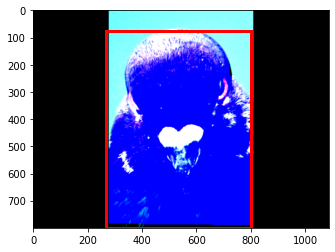

1


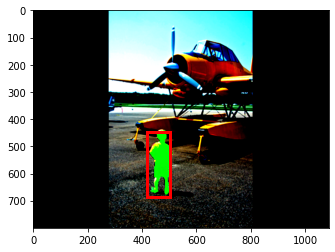

2


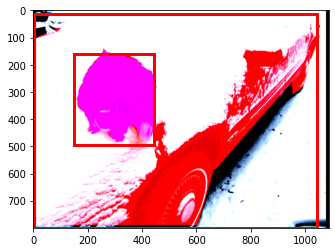

1


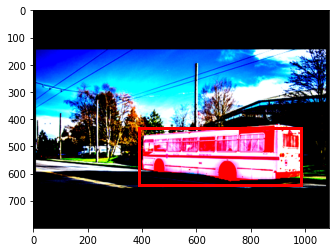

2


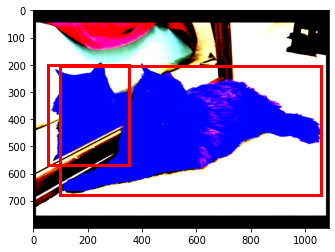

1


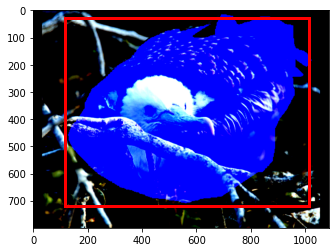

1


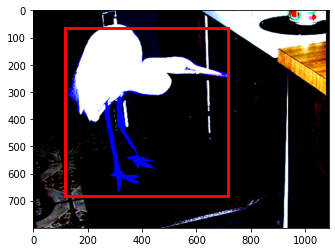

2


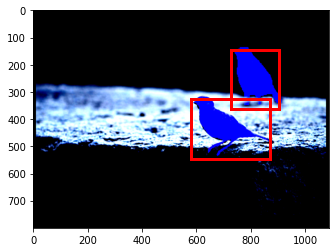

1


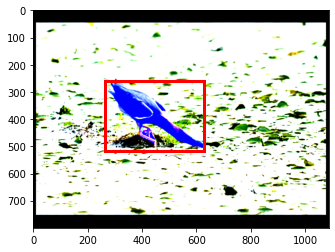

1


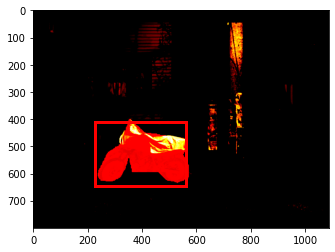

In [ ]:
# Show the chosen image with ground truth bounding boxes visualized.
from matplotlib.patches import Rectangle


def visualise_labels(images, labels, masks, bboxes ):
  for img,lbl,msk,bbx in zip(images, labels, masks, bboxes):
  
      plt.figure()
      plt.axes()
  
      plot=img.numpy()
      plot= np.moveaxis(plot,0,-1)
      print(len(lbl))
      for i in range(len(lbl)):
          show_mask= msk[i].numpy()
          if lbl[i]==0:
            pass
          if lbl[i]==1:
              plot[:,:,0] += show_mask*3 
          if lbl[i]==2:
              plot[:,:,1] += show_mask*3 
          if lbl[i]==3:
              plot[:,:,2] += show_mask*3 

      plt.imshow(np.clip(plot,0,1))

      for i in range(len(bbx)):
          rectangle = plt.Rectangle((bbx[i][0],bbx[i][1]), bbx[i][2]-bbx[i][0],bbx[i][3]-bbx[i][1],fill=False, ec='r', lw=3)
          plt.gca().add_patch(rectangle)

      plt.show()
dataloader = DataLoader(image_ds, batch_size=10,shuffle=True, collate_fn=collate_fn)
images, labels, masks, bboxes = next(iter(dataloader))
visualise_labels(images, labels, masks, bboxes )

### Model
#### Architecture
The model architecture is summarized in fig. 7 and tables 1 and 2.

<div><img src="https://github.com/LukasZhornyak/CIS680_files/raw/main/HW3/fig7.png" width=500/></div>
<center>Figure 7: SOLO branch structure.</center>
<br>
<center>Table 1: Category branch structure.</center>

| Layer | Hyperparameters |
| :--- | :--- |
| conv1 | Kernel size $= 3\times3\times256$, stride $= 1$, pad $= 1$, bias $= \text{False}$. <br> Followed by GroupNorm, num_groups $=32$ and ReLU |
| conv2 | Kernel size $= 3\times3\times256$, stride $= 1$, pad $= 1$, bias $= \text{False}$. <br> Followed by GroupNorm, num_groups $=32$ and ReLU |
| conv3 | Kernel size $= 3\times3\times256$, stride $= 1$, pad $= 1$, bias $= \text{False}$. <br> Followed by GroupNorm, num_groups $=32$ and ReLU |
| conv4 | Kernel size $= 3\times3\times256$, stride $= 1$, pad $= 1$, bias $= \text{False}$. <br> Followed by GroupNorm, num_groups $=32$ and ReLU |
| conv5 | Kernel size $= 3\times3\times256$, stride $= 1$, pad $= 1$, bias $= \text{False}$. <br> Followed by GroupNorm, num_groups $=32$ and ReLU |
| conv6 | Kernel size $= 3\times3\times256$, stride $= 1$, pad $= 1$, bias $= \text{False}$. <br> Followed by GroupNorm, num_groups $=32$ and ReLU |
| conv7 | Kernel size $= 3\times3\times256$, stride $= 1$, pad $= 1$, bias $= \text{False}$. <br> Followed by GroupNorm, num_groups $=32$ and ReLU |
| conv_out | Kernel size $= 3\times3\times(C-1)$, stride $= 1$, pad $= 1$, bias $= \text{True}$. <br> Followed by Sigmoid layer. Note $C = 4$ here (number of classes + background). |

<br>
<center>Table 2: Mask branch structure.</center>

| Layer | Hyperparameters |
| :--- | :--- |
| conv1 | Kernel size $= 3\times3\times(256 + 2)$, stride $= 1$, pad $= 1$, bias $= \text{False}$. <br> Two additional input channels represent the $x$ and $y$ positional encoding. <br> Followed by GroupNorm, num_groups $=32$ and ReLU |
| conv2 | Kernel size $= 3\times3\times256$, stride $= 1$, pad $= 1$, bias $= \text{False}$. <br> Followed by GroupNorm, num_groups $=32$ and ReLU |
| conv3 | Kernel size $= 3\times3\times256$, stride $= 1$, pad $= 1$, bias $= \text{False}$. <br> Followed by GroupNorm, num_groups $=32$ and ReLU |
| conv4 | Kernel size $= 3\times3\times256$, stride $= 1$, pad $= 1$, bias $= \text{False}$. <br> Followed by GroupNorm, num_groups $=32$ and ReLU |
| conv5 | Kernel size $= 3\times3\times256$, stride $= 1$, pad $= 1$, bias $= \text{False}$. <br> Followed by GroupNorm, num_groups $=32$ and ReLU |
| conv6 | Kernel size $= 3\times3\times256$, stride $= 1$, pad $= 1$, bias $= \text{False}$. <br> Followed by GroupNorm, num_groups $=32$ and ReLU |
| conv7 | Kernel size $= 3\times3\times256$, stride $= 1$, pad $= 1$, bias $= \text{False}$. <br> Followed by GroupNorm, num_groups $=32$ and ReLU |
| conv_out | Kernel size $= 1\times1\times(\text{num_grid})^2$, stride $= 1$, pad $= 0$, bias $= \text{True}$. <br> Followed by Sigmoid layer. Note that $\text{num_grid}$ is different for each layer of the FPN. |

We will be using a pretrained backbone (which includes an FPN), so you will not have to implement those components. A template for the network with along with default parameters is shown below.

#### Feature Pyramid
The feature pyramid extracted below has strides $[4,8,16,32,64]$ over the original image. To match the SOLO paper, this should be interpolated to have strides $[8,8,16,32,32]$.

#### Target Assignment
Some notes about generating the ground truth targets:
* The FPN levels can be though of as different grid sizes cut through the image.
* You assign each target to a certain FPN level if $\sqrt{wh}$ from the bounding box falls within the `scale_range` associated with that level. Note that these overlap, so you may assign the same target to multiple levels.
* A grid cell should be considered as predicting an object if that grid cell falls into the "centre region" of the object.
 * The centre region of an object is its bounding box scaled by `epsilon`.
 * Each grid cell can predict at most one object, but each object can be predicted by more than one grid cell.
 
#### Target Visualization
You should produce visualizations such as fig. 8 and 9 to validate your target assignments.

<div><img src="https://github.com/LukasZhornyak/CIS680_files/raw/main/HW3/fig8.png" width=500/></div>
<center>Figure 8: Target assignment example.</center>

<div><img src="https://github.com/LukasZhornyak/CIS680_files/raw/main/HW3/fig9.png" width=500/></div>
<center>Figure 9: Target assignment example.</center>

In [ ]:
import pytorch_lightning as pl

class SOLO(pl.LightningModule):
    _default_cfg = {
        'num_classes': 4,
        'in_channels': 256,
        'seg_feat_channels': 256,
        'stacked_convs': 7,
        'strides': [8, 8, 16, 32, 32],
        'scale_ranges': [(1, 96), (48, 192), (96, 384), (192, 768), (384, 2048)],
        'epsilon': 0.2,
        'num_grids': [40, 36, 24, 16, 12],
        'mask_loss_cfg': dict(weight=3),
        'cate_loss_cfg': dict(gamma=2, alpha=0.25, weight=1),
        'postprocess_cfg': dict(cate_thresh=0.2, mask_thresh=0.5, pre_NMS_num=50, keep_instance=5, IoU_thresh=0.5)
    }
    
    def __init__(self, **kwargs):
        super().__init__()
        for k, v in {**self._default_cfg, **kwargs}.items():
            setattr(self, k, v)
        
        pretrained_model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=False, pretrained_backbone=True)
        self.backbone = pretrained_model.backbone
        self.num_training_steps = 0
        
        self.cat_seq = nn.Sequential(
          nn.Conv2d(256, 256, (3, 3), stride=1, padding=1, bias=False),
          nn.GroupNorm(32, 256),
          nn.ReLU(),
          nn.Conv2d(256, 256, (3, 3), stride=1, padding=1, bias=False),
          nn.GroupNorm(32, 256),
          nn.ReLU(),
          nn.Conv2d(256, 256, (3, 3), stride=1, padding=1, bias=False),
          nn.GroupNorm(32, 256),
          nn.ReLU(),
          nn.Conv2d(256, 256, (3, 3), stride=1, padding=1, bias=False),
          nn.GroupNorm(32, 256),
          nn.ReLU(),
          nn.Conv2d(256, 256, (3, 3), stride=1, padding=1, bias=False),
          nn.GroupNorm(32, 256),
          nn.ReLU(),
          nn.Conv2d(256, 256, (3, 3), stride=1, padding=1, bias=False),
          nn.GroupNorm(32, 256),
          nn.ReLU(),
          nn.Conv2d(256, 256, (3, 3), stride=1, padding=1, bias=False),
          nn.GroupNorm(32, 256),
          nn.ReLU(),
          nn.Conv2d(256, 3, (3, 3), stride=1, padding=1, bias=True),
          nn.Sigmoid()
        )

        self.mask_seq = nn.Sequential(nn.Conv2d(258, 256, (3, 3), stride=1, padding=1, bias=False),
                                      nn.GroupNorm(32, 256),
                                      nn.ReLU(),
                                      nn.Conv2d(256, 256, (3, 3), stride=1, padding=1, bias=False),
                                      nn.GroupNorm(32, 256),
                                      nn.ReLU(),
                                      nn.Conv2d(256, 256, (3, 3), stride=1, padding=1, bias=False),
                                      nn.GroupNorm(32, 256),
                                      nn.ReLU(),
                                      nn.Conv2d(256, 256, (3, 3), stride=1, padding=1, bias=False),
                                      nn.GroupNorm(32, 256),
                                      nn.ReLU(),
                                      nn.Conv2d(256, 256, (3, 3), stride=1, padding=1, bias=False),
                                      nn.GroupNorm(32, 256),
                                      nn.ReLU(),
                                      nn.Conv2d(256, 256, (3, 3), stride=1, padding=1, bias=False),
                                      nn.GroupNorm(32, 256),
                                      nn.ReLU(),
                                      nn.Conv2d(256, 256, (3, 3), stride=1, padding=1, bias=False),
                                      nn.GroupNorm(32, 256),
                                      nn.ReLU())


        self.mask_conv_out_4 = nn.Conv2d(256,self.num_grids[0]*self.num_grids[0] , (1, 1), stride=1, padding=0, bias=True)
        self.mask_conv_out_8 = nn.Conv2d(256,self.num_grids[1]*self.num_grids[1], (1, 1), stride=1, padding=0, bias=True)
        self.mask_conv_out_16 = nn.Conv2d(256,self.num_grids[2]*self.num_grids[2], (1, 1), stride=1, padding=0, bias=True)
        self.mask_conv_out_32 = nn.Conv2d(256,self.num_grids[3]*self.num_grids[3], (1, 1), stride=1, padding=0, bias=True)
        self.mask_conv_out_64 = nn.Conv2d(256,self.num_grids[4]*self.num_grids[4], (1, 1), stride=1, padding=0, bias=True)
        #self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.pos_enc_8 = self.gen_pos_enc(size = (100,136))
        self.pos_enc_16 = self.gen_pos_enc(size = (50,68))
        self.pos_enc_32 = self.gen_pos_enc(size = (25,34))
    # Forward function should calculate across each level of the feature pyramid network.
    # Input:
    #     images: batch_size number of images
    # Output:
    #     if eval = False
    #         category_predictions: list, len(fpn_levels), each (batch_size, C-1, S, S)
    #         mask_predictions:     list, len(fpn_levels), each (batch_size, S^2, 2*feature_h, 2*feature_w)
    #     if eval==True
    #         category_predictions: list, len(fpn_levels), each (batch_size, S, S, C-1)
    #         / after point_NMS
    #         mask_predictions:     list, len(fpn_levels), each (batch_size, S^2, image_h/4, image_w/4)
    #         / after upsampling

    def category_forward(self,fp,index):
      # Category branch'
        # cat_x = F.interpolate(fp, size=(self.num_grids[index],self.num_grids[index]),
        #                        mode='bilinear', align_corners=True)
        # cat_x = F.relu(self.cat_conv1_gn(self.cat_conv1(cat_x)))
        # cat_x = F.relu(self.cat_conv2_gn(self.cat_conv2(cat_x)))
        # cat_x = F.relu(self.cat_conv3_gn(self.cat_conv3(cat_x)))
        # cat_x = F.relu(self.cat_conv4_gn(self.cat_conv4(cat_x)))
        # cat_x = F.relu(self.cat_conv5_gn(self.cat_conv5(cat_x)))
        # cat_x = F.relu(self.cat_conv6_gn(self.cat_conv6(cat_x)))
        # cat_x = F.relu(self.cat_conv7_gn(self.cat_conv7(cat_x)))
        # cat_x = F.sigmoid(self.cat_conv_out(cat_x))
        cat_x = self.cat_seq(F.interpolate(fp, size=(self.num_grids[index],self.num_grids[index]),
                               mode='bilinear', align_corners=True)).permute([0,2,3,1])
        return cat_x
    
    def gen_pos_enc(self,size):
        grid_size_x = size[0]
        grid_size_y = size[1]
        x = torch.arange(grid_size_x).unsqueeze(-1)/grid_size_x
        y = torch.arange(grid_size_y).unsqueeze(0)/grid_size_y
        x = x.repeat(1,grid_size_y)
        y = y.repeat(grid_size_x,1)
        x = x.unsqueeze(0).unsqueeze(0)
        y = y.unsqueeze(0).unsqueeze(0)
        # print(x.shape)
        # print(y.shape)
        return torch.cat((x,y),dim = 1)

    def mask_forward(self,fp):
        batch_size = fp.shape[0]
        #print(fp.shape)
        if(fp.shape[2]==100 & fp.shape[3]==136):
          pos_enc = pos_enc_8
        elif(fp.shape[2]==50 & fp.shape[3]==68):
          pos_enc = pos_enc_16
        elif(fp.shape[2]==25 & fp.shape[3]==34):
          pos_enc = pos_enc_32
        else:
            pos_enc = self.gen_pos_enc(size =(fp.shape[2],fp.shape[3]) )
        #print(pos_enc.shape)
        mask_x = self.mask_seq(torch.cat((fp,pos_enc.repeat(batch_size,1,1,1).to(self.device)),axis=1))
        # mask_x = F.relu(self.mask_conv1_gn(self.mask_conv1(mask_x)))
        # mask_x = F.relu(self.mask_conv2_gn(self.mask_conv2(mask_x)))
        # mask_x = F.relu(self.mask_conv3_gn(self.mask_conv3(mask_x)))
        # mask_x = F.relu(self.mask_conv4_gn(self.mask_conv4(mask_x)))
        # mask_x = F.relu(self.mask_conv5_gn(self.mask_conv5(mask_x)))
        # mask_x = F.relu(self.mask_conv6_gn(self.mask_conv6(mask_x)))
        # mask_x = F.relu(self.mask_conv7_gn(self.mask_conv7(mask_x)))
        return mask_x

    def forward(self, images, eval=True):
        # you can modify this if you want to train the backbone
        feature_pyramid = [v.detach() for v in self.backbone(images).values()] # this has strides [4,8,16,32,64]
        feature_pyramid[0] = nn.functional.interpolate(feature_pyramid[0], scale_factor=0.5,mode='bilinear',align_corners=True)
        #feature_pyramid[4] = nn.functional.interpolate(feature_pyramid[4], scale_factor=2)
        feature_pyramid[4] = nn.functional.interpolate(feature_pyramid[4],
              size=(feature_pyramid[3].shape[2],feature_pyramid[3].shape[3]),align_corners=True,mode='bilinear')

        # for fp in feature_pyramid:
        #   print(fp.shape)
        # Category branch
        
        cat_x = [self.cat_seq(F.interpolate(feature_pyramid[j], size=(self.num_grids[j],self.num_grids[j]),
                               mode='bilinear', align_corners=True)).permute([0,2,3,1]) for j in range(len(feature_pyramid)) ]
        # Mask branch
        mask_x =  [self.mask_forward(fp) for fp in feature_pyramid ]

        # mask_x[0] =  F.interpolate(F.sigmoid(self.mask_conv_out_4(mask_x[0])),scale_factor=2,mode='bilinear',align_corners=True)
        # mask_x[1] =  F.interpolate(F.sigmoid(self.mask_conv_out_8(mask_x[1])),scale_factor=2,mode='bilinear',align_corners=True)
        # mask_x[2] =  F.interpolate(F.sigmoid(self.mask_conv_out_16(mask_x[2])),scale_factor=2,mode='bilinear',align_corners=True)
        # mask_x[3] =  F.interpolate(F.sigmoid(self.mask_conv_out_32(mask_x[3])),scale_factor=2,mode='bilinear',align_corners=True)
        # mask_x[4] =  F.interpolate(F.sigmoid(self.mask_conv_out_64(mask_x[4])),scale_factor=2,mode='bilinear',align_corners=True)
        mask_x[0] =  F.interpolate(F.sigmoid(self.mask_conv_out_4(mask_x[0])),scale_factor=2,mode='bilinear',align_corners=True)
        mask_x[1] =  F.interpolate(F.sigmoid(self.mask_conv_out_8(mask_x[1])),scale_factor=2,mode='bilinear',align_corners=True)
        mask_x[2] =  F.interpolate(F.sigmoid(self.mask_conv_out_16(mask_x[2])),scale_factor=2,mode='bilinear',align_corners=True)
        mask_x[3] =  F.interpolate(F.sigmoid(self.mask_conv_out_32(mask_x[3])),scale_factor=2,mode='bilinear',align_corners=True)
        mask_x[4] =  F.interpolate(F.sigmoid(self.mask_conv_out_64(mask_x[4])),scale_factor=2,mode='bilinear',align_corners=True)
        # for j in range(len(mask_x)):
        #   print(mask_x[j].shape)
        #   print(cat_x[j].shape)
        return cat_x, mask_x   
        
    # This function build the ground truth tensor for each batch in the training
    # Input:
    #     bounding_boxes:   list, len(batch_size), each (n_object, 4) (x1 y1 x2 y2 system)
    #     labels:           list, len(batch_size), each (n_object, )
    #     masks:            list, len(batch_size), each (n_object, 800, 1088)
    # Output:
    #     category_targets: list, len(batch_size), list, len(fpn), (S, S), values are {1, 2, 3}
    #     mask_targets:     list, len(batch_size), list, len(fpn), (S^2, 2*feature_h, 2*feature_w)
    #     active_masks:     list, len(batch_size), list, len(fpn), (S^2,)
    #     / boolean array with positive mask predictions
    
    def loss(self,cat_pred,mask_pred,cat_target, mask_target,active_masks):
      alpha = self.cate_loss_cfg['alpha']
      gamma = self.cate_loss_cfg['gamma']
      self.focal_loss_level = []
      self.dice_loss_level = []
      self.focal_loss = torch.zeros((1,)).to(self.device)
      self.dice_loss = torch.zeros((1,)).to(self.device)
      for level in range((len(self.strides))):
        cat_target_onehot = F.one_hot(torch.tensor(torch.stack(cat_target[:,level].tolist()),dtype=torch.int64),num_classes = 4)
        cat_target_onehot = cat_target_onehot[:,:,:,-3:].to(self.device)
        #pred_sigmoid = torch.tensor(cat_pred[:][level],dtype= torch.float32).sigmoid()
        # print(cat_target_onehot.device)
        # print(cat_pred[level].shape)
        pt =  cat_pred[level] * cat_target_onehot +(1 - cat_pred[level]) * (1 - cat_target_onehot)
        # print(pt.shape)
        focal_weight = (alpha * cat_target_onehot  + (1 - alpha) *
                      (1 - cat_target_onehot)) * (1 - pt).pow(gamma)
        #print(focal_weight.shape)
        factor = cat_target_onehot.shape[1]*cat_target_onehot.shape[2]*cat_target_onehot.shape[3]
        focal_loss_level = - focal_weight*torch.log(pt)/factor
        # print(focal_loss_level.shape)
        self.focal_loss_level.append(focal_loss_level)
        self.focal_loss += torch.sum(focal_loss_level)

      for j in range(len(cat_target)):
        for level in range((len(self.strides))):
          active_masks_level = active_masks[j,level].to(self.device)
          #print((active_masks_level>0).shape)
          active_masks_level = active_masks_level>0
          N_pos = torch.sum(active_masks_level)
          if(N_pos.cpu().item()==0):
            continue
          mask_pred_target =  mask_pred[level][j,active_masks_level,:,:]
          
          #mask_pred_sigmoid = torch.tensor(mask_pred_target,dtype=torch.float32).sigmoid()
          
          
          #print(N_pos)
          mask_grnd_target = mask_target[j,level][active_masks_level>0,:,:]
          #print(mask_pred_target.shape)
          #print(mask_grnd_target.shape)
          denom = torch.sum(mask_pred_target*mask_pred_target + mask_grnd_target*mask_grnd_target,dim=(1,2))
          num = torch.sum(2*mask_pred_target*mask_grnd_target,dim=(1,2))
          d_target_pred = num/denom
          dice_loss = 1/N_pos.cpu()*(1 - d_target_pred)
          self.dice_loss_level.append(dice_loss)
          self.dice_loss += torch.sum(dice_loss).to(self.device)
      # print(self.focal_loss)
      # print(self.dice_loss)
      
      self.total_loss = self.cate_loss_cfg['weight']*self.focal_loss + self.mask_loss_cfg['weight']*self.dice_loss
      # print(self.total_loss)
      return self.focal_loss,self.dice_loss,self.total_loss

    def training_step(self, batch, batch_idx):
        images, labels, masks, bboxes  = batch
        cat_pred, mask_pred = self.forward(images)
        category_targets,mask_targets,active_masks = self.generate_targets(bboxes,labels,masks)
        category_targets = np.array(category_targets,dtype=np.object)
        mask_targets = np.array(mask_targets,dtype=np.object)
        active_masks = np.array(active_masks,dtype=np.object)
        focal_loss,mask_loss,loss = self.loss(cat_pred,mask_pred,category_targets,mask_targets,active_masks)
        self.log('train_focal_oss',focal_loss)
        self.log('train_mask_loss',mask_loss)
        self.log('train_total_loss', loss) 
        #self.scheduler.step()
        del category_targets,mask_targets,active_masks,cat_pred,mask_pred
        self.num_training_steps += 1  
        return {"focal_loss": focal_loss,"mask_loss": mask_loss,"loss": loss}
    
    def training_epoch_end(self, training_step_outputs):
      for pred in training_step_outputs:
        pass
      self.scheduler.step()
    
    def validation_step(self, batch, batch_idx):
        images, labels, masks, bboxes  = batch
        cat_pred, mask_pred = self.forward(images)
        category_targets,mask_targets,active_masks = self.generate_targets(bboxes,labels,masks)
        category_targets = np.array(category_targets,dtype=np.object)
        mask_targets = np.array(mask_targets,dtype=np.object)
        active_masks = np.array(active_masks,dtype=np.object)
        focal_loss,mask_loss,loss = self.loss(cat_pred,mask_pred,category_targets,mask_targets,active_masks)
        self.log('val_focal_Loss',focal_loss)
        self.log('val_mask_loss',mask_loss)
        self.log('val_total_loss', loss) 
        return {"focal_loss": focal_loss,"mask_loss": mask_loss,"loss": loss}

    def generate_targets(self, bounding_boxes, labels, masks):
      category_targets = [[] for j in range(len(bounding_boxes))]
      mask_targets = [[] for j in range(len(bounding_boxes))]
      active_masks = [[] for j in range(len(bounding_boxes))]
      orig_w = masks
      
      for i in range(len(bounding_boxes)):
        #Number of feature pyramids
        category_target = [[] for j in range(len(self.strides))]
        mask_target = [[] for j in range(len(self.strides))]
        active_mask = [[] for j in range(len(self.strides))]
        for j in range((len(self.strides))):
            feature_w = int(2*800/self.strides[j])
            feature_h = int(2*1088/self.strides[j])
            category_target_fp = torch.zeros((self.num_grids[j],self.num_grids[j])).to(self.device)
            mask_target_fp =[]
            active_mask_fp = torch.zeros((self.num_grids[j]*self.num_grids[j])).to(self.device)

            #print(self.num_grids[j])
            # print(x_bin_lt)
            # print(y_bin_lt)
            # print(x_bin_rt)
            # print(y_bin_rt)
            convert_mask = F.interpolate(masks[i].unsqueeze(dim=0).type(torch.float32),size = (feature_w,feature_h),mode = 'nearest')
            for k in range(labels[i].shape[0]):
              box = bounding_boxes[i][k]
              h = box[2] - box[0]
              w = box[3] - box[1]
              # print(x_bin_lt)
              # print(y_bin_lt)
              # print(x_bin_rt)
              # print(y_bin_rt)
              if(np.sqrt(h*w)>self.scale_ranges[j][0] and np.sqrt(h*w)<=self.scale_ranges[j][1]):
                # if ((x_bin[k]*self.num_grids[j]+y_bin[k])>active_mask_fp.shape[0]):
                #   print(self.num_grids[j])
                #   print(x_bin[k])
                #   print(y_bin[k])
                #print(np.sqrt(h*w))
                cx,cy = ndimage.measurements.center_of_mass(masks[i][k].cpu().detach().numpy().astype(int))
                cx,cy = torch.tensor(cx),torch.tensor(cy)
                box = bounding_boxes[i][k]
                h = box[2] - box[0]
                w = box[3] - box[1]
                x_bin_lt = int((cx - self.epsilon*w)/(800/self.num_grids[j]))
                y_bin_lt = int((cy - self.epsilon*h)/(1088/self.num_grids[j]))
                x_bin_rt = int((cx + self.epsilon*w)/(800/self.num_grids[j]))
                y_bin_rt = int((cy + self.epsilon*h)/(1088/self.num_grids[j]))
                mesh_x, mesh_y = torch.meshgrid([torch.arange(x_bin_lt, x_bin_rt + 1), torch.arange(y_bin_lt, y_bin_rt + 1)])
                # print(mesh_x,mesh_y)
                # print(mesh_x.reshape(-1)*self.num_grids[j] + mesh_y.reshape(-1))
                active_mask_fp[mesh_x.reshape(-1)*self.num_grids[j] + mesh_y.reshape(-1)] = 1
                mask_target_fp = torch.zeros((self.num_grids[j]*self.num_grids[j],feature_w,feature_h )).to(self.device)
                category_target_fp[x_bin_lt:x_bin_rt+1,y_bin_lt:y_bin_rt+1] = labels[i][k]
                mask_target_fp[mesh_x.reshape(-1)*self.num_grids[j] + mesh_y.reshape(-1)] = convert_mask[0][k].to(self.device)
            category_target[j] = category_target_fp
            mask_target[j] = mask_target_fp
            active_mask[j] = active_mask_fp
        category_targets[i] = category_target
        mask_targets[i] = mask_target
        active_masks[i] = active_mask
      
      return category_targets,mask_targets,active_masks
    
    def configure_optimizers(self): 
      self.optim = torch.optim.SGD(self.parameters(),lr = 0.01/4,weight_decay=1e-4,momentum=0.90)
      self.scheduler = torch.optim.lr_scheduler.MultiStepLR(self.optim, milestones=[27,33], gamma=0.10)
      return self.optim

In [ ]:
torch.arange(10)

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [ ]:
torch.cuda.empty_cache()
!nvidia-smi

Sat Oct 23 00:56:22 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.74       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# model = SOLO()
# model = model
# dataloader = DataLoader(image_ds, batch_size=2,shuffle=True, collate_fn=collate_fn)
# images, labels, masks, bboxes = next(iter(dataloader))

# # print(model.device)
# a,b = model(images)
# cat_targets,mask_targets,active_masks = model.generate_targets( bboxes, labels, masks)
# cat_targets = np.array(cat_targets,dtype=np.object)
# mask_targets = np.array(mask_targets,dtype=np.object)
# active_masks = np.array(active_masks,dtype=np.object)
# print(len(cat_targets[:,0]))
# fl,dl,tl = model.loss(a,b,cat_targets,mask_targets,active_masks)
# del model,a,b

In [ ]:
# c = [[1,2],[2,3],[3,4],[4,5]]
# print(c[:,0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


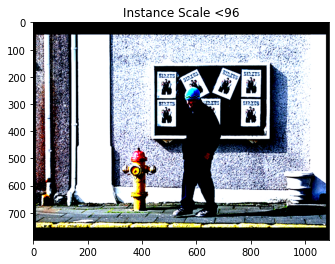

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


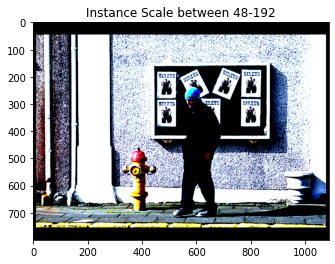

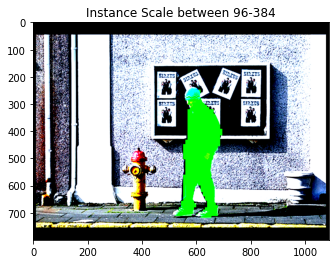

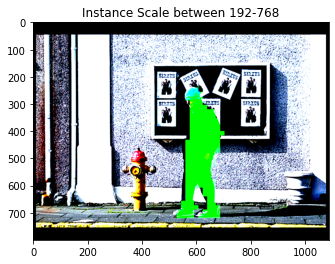

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


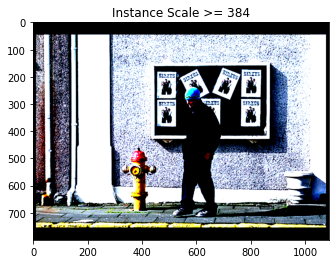

In [ ]:
def plots(masks,labels,active_mask,img):
    for i in range(len(masks)):
      for j in range(len(masks[i])):
          #print(labels[i][j].shape)        
          idx = torch.nonzero(labels[i][j] > 0,as_tuple=False)
          mask_idx =  torch.nonzero(active_mask[i][j] > 0,as_tuple=False).flatten().tolist()
          #print(idx)
          #print("FPN Level", j)
          if (len(idx) == 0):
            plot=img[i].numpy()
            plot= np.moveaxis(plot,0,-1)
            plt.figure()
            plt.imshow(plot)
            if j==0:
              plt.title("Instance Scale <96")
            if j==1:
              plt.title("Instance Scale between 48-192")
            if j==2:
              plt.title("Instance Scale between 96-384")
            if j==3:
              plt.title("Instance Scale between 192-768")
            if j==4:
              plt.title("Instance Scale >= 384")
            plt.show()
            continue
          #print(idx.shape)
          #print(mask_idx)
          mask = masks[i][j][mask_idx].unsqueeze(0)

          mask_resize = F.interpolate(mask, size=(img.shape[-2],img.shape[-1]), mode='nearest')
          #print(mask.shape)
          label = labels[i][j][labels[i][j]>0]
          #print(label)
          plt.figure()        
          n = label.shape[0] 
          #print(n)
          mask_resize = mask_resize.squeeze(0)
          #print(mask_resize.shape)
          img2 = img.squeeze(0).numpy().copy()
          img2= np.moveaxis(img2,0,-1)
          for k in range(n):
            c = label[k]
            mask2 = mask_resize[k]
            #print(mask2.shape)
            if (c == 1):
              img2[mask2 == 1,0] = 1
            if (c == 2):
              img2[mask2 == 1,1] = 1
            if (c == 3):
              img2[mask2 == 1,2] = 1

          plt.imshow(np.clip(img2,0,1))
          if j==0:
            plt.title("Instance Scale <96")
          if j==1:
            plt.title("Instance Scale between 48-192")
          if j==2:
            plt.title("Instance Scale between 96-384")
          if j==3:
            plt.title("Instance Scale between 192-768")
          if j==4:
            plt.title("Instance Scale >= 384")
          plt.show()

def visualise_targets(images, labels, masks, bboxes ):
  model = SOLO()

  for img,lbl,msk,bbx in zip(images, labels, masks, bboxes):  
    img = img.unsqueeze(dim  = 0)
    lbl = [lbl]
    msk = [msk]
    bbx = [bbx]
    cat_targets,mask_targets,active_mask = model.generate_targets( bbx, lbl, msk)
    #print(len(cat_targets))
    plots(mask_targets,cat_targets,active_mask,img)
  

dataloader = DataLoader(image_ds, batch_size=1,shuffle=True, collate_fn=collate_fn)
images, labels, masks, bboxes = next(iter(dataloader))
visualise_targets(images, labels, masks, bboxes )

### Part A Submission
In addition to the code you used, you should submit a pdf containing the following plots:
* Dataset visualization plots such as fig. 5 and 6. You should include at least five examples and at least two examples that contain multiple objects. Additionally, the images should cover a range of scales and object classes.
* Target assignment plots such as fig. 8 and 9. Should include at least five examples and at least two examples that contain multiple objects. Additionally, the images should cover a range of scales and object classes.

We should be able to reproduce your results with a single function call or cell evaluation. Please specify the method to do so.

# **Code segments to produce visualisations**

Run the following Cells in order to obtain results

Note: Since we shuffle through the data the obtained images in th eoutput would be different. This was done to ensure that we were able to capture multi-object instances.

In [ ]:
#Basic Initialization

#Code:
 #setting path in colab
 #mount the drive first
from google.colab import drive
drive.mount('/content/drive/', force_remount= True)

#click on the URL and copy the code. paste it in the box and press enter
import os

#set the working directory 

root_dir = "/content/drive/My Drive/"

#choose the project folder
project_folder = "CIS680HW/HW3/"

#define a function to create and set the working directory
def create_and_set_working_directory(project_folder):
  #check if the project folder exists. if not, make one.
  if os.path.isdir(root_dir + project_folder) == False:
    os.mkdir(root_dir + project_folder)
    print(root_dir + project_folder + 'did not existed and was created.')
  
  #change the OS path to project folder as working directory
  os.chdir(root_dir + project_folder)

  #create a test file in the working directory and see if it shows up at the right place
  !touch 'new_file_test.txt'
  print('working directory' + root_dir + project_folder + \
        "empty text file created. You can also run !pwd command to confirm working directory.")

create_and_set_working_directory(project_folder)

Mounted at /content/drive/
working directory/content/drive/My Drive/CIS680HW/HW3/empty text file created. You can also run !pwd command to confirm working directory.


In [ ]:
# images:         (batch_size, 3, 800, 1088)
# labels:         list with len: batch_size, each (n_obj,)
# masks:          list with len: batch_size, each (n_obj, 800,1088)
# bounding_boxes: list with len: batch_size, each (n_obj, 4)
import os
import numpy as np
import torch
import torchvision
from torchvision import transforms, datasets
from torch import nn, optim
from matplotlib import pyplot as plt
from torch.utils import data
from torch.utils.data import DataLoader
import torch.nn.functional as F
import pytorch_lightning as pl
import pytorch_lightning.loggers as pl_loggers
import pytorch_lightning.callbacks as pl_callbacks

import pickle
import h5py
#import helpers

import cv2
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from sklearn.model_selection import train_test_split
import xml.etree.ElementTree as ET

In [ ]:
class SOLODataset(data.Dataset):
  def __init__ (self, path):
    self.masks = h5py.File(path[0])['data']
    self.img = h5py.File(path[1])['data']
    self.lab = np.array(np.load(path[2], allow_pickle=True))
    self.bbox =  np.array(np.load(path[3],allow_pickle=True))

    self.transform = transforms.Compose([
         transforms.Resize((800, 1066)),
         transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
         transforms.Pad((11,0))])
    self.transform_mask = transforms.Compose([
         transforms.Resize((800, 1066)),
         transforms.Pad((11,0))])
    # self.transform = transforms.Compose([
    #   transforms.Pad((0,11)),
    #   transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    #   transforms.Resize((800, 1066)),
    #   transforms.ToTensor()])
  def __len__(self):
        return len(self.img)

  def __getitem__(self, idx):
      #pass
    # #img_path = os.path.join(self.images, label = self.labels.iloc[idx, 1] )
    # image = read_image(img_path)
    # label = self.labels.iloc[idx, 1]
    # if self.image_transform:
    #     image = self.image_transform(image)
    # if self.target_transform:
    #     label = self.target_transform(label)
    # return image, label
    mask_numb = 0
    mask_numb_end = 0      
    
    for i in range(idx):
        mask_numb+=len(self.lab[i])
    #print(len(labels[idx]))
    mask_numb_end = mask_numb + len(self.lab[idx])
    
    img = self.transform(torch.tensor(self.img[idx]/255,dtype=torch.float32))
    masks = self.transform_mask(torch.tensor(self.masks[mask_numb:mask_numb_end]/1.0,dtype=torch.int32))
    bbox = self.bbox[idx]*2.667# Rescaling the bounding boxes
    bbox[:,[1,3]] += 11
    sample = img,self.lab[idx],masks,bbox

    return sample
    
def collate_fn(batch):
  image_list =[]
  label_list = []
  masks_list = []
  bounding_boxes_list = []

  for images,labels,masks,boxes in batch:
    image_list.append(images)
    label_list.append(labels)
    masks_list.append(masks)
    bounding_boxes_list.append(boxes)

  return torch.stack(image_list,dim = 0), label_list, masks_list, bounding_boxes_list

In [ ]:

paths = ['data/hw3_mycocodata_mask_comp_zlib.h5','data/hw3_mycocodata_img_comp_zlib.h5','data/hw3_mycocodata_labels_comp_zlib.npy','data/hw3_mycocodata_bboxes_comp_zlib.npy']
image_ds = SOLODataset(paths)

print ("Visualisations for Target Assignment")
dataloader = DataLoader(image_ds, batch_size=10,shuffle=True, collate_fn=collate_fn)
images, labels, masks, bboxes = next(iter(dataloader))
print('Labels')
visualise_labels(images.clone(), labels.copy(), masks.copy(), bboxes.copy() )

print('Target Assignment')
visualise_targets(images, labels, masks, bboxes )

Visualisations for Target Assignment
Labels


NameError: ignored

## Part B
### Loss
The loss function consists of two parts: category loss and mask loss:
$$L = \lambda_\text{cate} L_\text{cate} + \lambda_\text{mask} L_\text{mask} $$

The category loss is defined as (where $\text{FL}$ is the focal loss)

$$L_\text{cate} = \frac{1}{S^2 C} \sum_{S,S,C} \text{FL}(p_t)$$

$$\text{FL}(p_t) = -\alpha_t (1 - p_t)^\gamma \log{(p_t)}$$

$$(\alpha_t, p_t) = \left\{\begin{array}{lr} (\alpha, \hat{p}) & \text{if }y=1 \\ (1 - \alpha, 1 - \hat{p}) & \text{otherwise}\end{array}\right.$$

while the mask loss is defined as (where $d_\text{mask}$ is the dice loss)

$$L_\text{mask} = \frac{1}{N_\text{positive}} \sum_k \mathbb{1}_{\{p_{i, j} > 0\}} d_\text{mask}(m_k, \hat{m}_k)$$

$$d_\text{mask}(p, q) = 1 - D(p, q)$$

$$D(p, q) = \frac{2 \sum_{x,y}(p_{x,y} \cdot q_{x,y})}{\sum_{x,y}p_{x,y}^2 + \sum_{x,y}q_{x,y}^2}$$

### Post Processing
Post processing consists of three steps: points NMS, concatenation and sorting, and matrix NMS. A summary of each of these steps is provided below. In addition, your final mask prediction should be a binary mask based on the mask thresholding parameter. Some examples of results post-inference are shown in figs. 11-14.


<div><img src="https://github.com/LukasZhornyak/CIS680_files/raw/main/HW3/fig11.png" width=300/></div>
<center>Figure 11: SOLO instance segmentation example.</center>

<div><img src="https://github.com/LukasZhornyak/CIS680_files/raw/main/HW3/fig12.png" width=300/></div>
<center>Figure 12: SOLO instance segmentation example.</center>

<div><img src="https://github.com/LukasZhornyak/CIS680_files/raw/main/HW3/fig13.png" width=300/></div>
<center>Figure 13: SOLO instance segmentation example.</center>

<div><img src="https://github.com/LukasZhornyak/CIS680_files/raw/main/HW3/fig14.png" width=300/></div>
<center>Figure 14: SOLO instance segmentation example.</center>

#### Points NMS
Non-max suppression for the category predictions, applied to each channel sperately. A maxpooling with a kernel size of 2, sample code is included below.

#### Concatenation and Sorting
Here, we merge the predictions across all the FPN levels into a single list of predictions, sorted by their predicted score. This involves rescaling the predicted masks appropriately.

#### Matrix NMS
Inspired by Soft-NMS, MatrixNMS suppresses mask predictions with a lower score based on their similarity to predictions with a higher score in a completely vectorized manner. Sample code is include below.

# **Run the following cells for Training**

In [2]:
#Basic Initialization

#Code:
 #setting path in colab
 #mount the drive first
from google.colab import drive
drive.mount('/content/drive/', force_remount= True)
import os

#set the working directory 

root_dir = "/content/drive/My Drive/"

#choose the project folder
project_folder = "CIS680HW/HW3/"

#define a function to create and set the working directory
def create_and_set_working_directory(project_folder):
  #check if the project folder exists. if not, make one.
  if os.path.isdir(root_dir + project_folder) == False:
    os.mkdir(root_dir + project_folder)
    print(root_dir + project_folder + 'did not existed and was created.')
  
  #change the OS path to project folder as working directory
  os.chdir(root_dir + project_folder)

  #create a test file in the working directory and see if it shows up at the right place
  !touch 'new_file_test.txt'
  print('working directory' + root_dir + project_folder + \
        "empty text file created. You can also run !pwd command to confirm working directory.")

create_and_set_working_directory(project_folder)

Mounted at /content/drive/
working directory/content/drive/My Drive/CIS680HW/HW3/empty text file created. You can also run !pwd command to confirm working directory.


In [3]:
# images:         (batch_size, 3, 800, 1088)
# labels:         list with len: batch_size, each (n_obj,)
# masks:          list with len: batch_size, each (n_obj, 800,1088)
# bounding_boxes: list with len: batch_size, each (n_obj, 4)
import os
import numpy as np
from scipy import ndimage

import torch
import torchvision
from torchvision import transforms, datasets
from torch import nn, optim
from matplotlib import pyplot as plt
from torch.utils import data
from torch.utils.data import DataLoader
import torch.nn.functional as F
import pytorch_lightning as pl
import pytorch_lightning.loggers as pl_loggers
import pytorch_lightning.callbacks as pl_callbacks

import pickle
import h5py
import time
#import helpers

import cv2
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from sklearn.model_selection import train_test_split
import xml.etree.ElementTree as ET

In [4]:

class SOLODataset(data.Dataset):
  def __init__ (self, path):
    self.masks = h5py.File(path[0])['data']
    self.img = h5py.File(path[1])['data']
    self.lab = np.array(np.load(path[2], allow_pickle=True))
    self.bbox =  np.array(np.load(path[3],allow_pickle=True))

    self.transform = transforms.Compose([
         transforms.Resize((800, 1066)),
         transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
         transforms.Pad((11,0))])
    self.transform_mask = transforms.Compose([
         transforms.Resize((800, 1066)),
         transforms.Pad((11,0))])
    # self.transform = transforms.Compose([
    #   transforms.Pad((0,11)),
    #   transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    #   transforms.Resize((800, 1066)),
    #   transforms.ToTensor()])
  def __len__(self):
        return len(self.img)

  def __getitem__(self, idx):
      #pass
    # #img_path = os.path.join(self.images, label = self.labels.iloc[idx, 1] )
    # image = read_image(img_path)
    # label = self.labels.iloc[idx, 1]
    # if self.image_transform:
    #     image = self.image_transform(image)
    # if self.target_transform:
    #     label = self.target_transform(label)
    # return image, label
    mask_numb = 0
    mask_numb_end = 0      
    
    for i in range(idx):
        mask_numb+=len(self.lab[i])
    #print(len(labels[idx]))
    mask_numb_end = mask_numb + len(self.lab[idx])
    
    img = self.transform(torch.tensor(self.img[idx]/255,dtype=torch.float32))
    masks = self.transform_mask(torch.tensor(self.masks[mask_numb:mask_numb_end]/1.0,dtype=torch.int32))
    bbox = self.bbox[idx]*2.667# Rescaling the bounding boxes
    bbox[:,[1,3]] += 11
    sample = img,self.lab[idx],masks,bbox

    return sample
    
def collate_fn(batch):
  image_list =[]
  label_list = []
  masks_list = []
  bounding_boxes_list = []

  for images,labels,masks,boxes in batch:
    image_list.append(images)
    label_list.append(labels)
    masks_list.append(masks)
    bounding_boxes_list.append(boxes)

  return torch.stack(image_list,dim = 0), label_list, masks_list, bounding_boxes_list

In [5]:
import pytorch_lightning as pl

class SOLO(pl.LightningModule):
    _default_cfg = {
        'num_classes': 4,
        'in_channels': 256,
        'seg_feat_channels': 256,
        'stacked_convs': 7,
        'strides': [8, 8, 16, 32, 32],
        'scale_ranges': [(1, 96), (48, 192), (96, 384), (192, 768), (384, 2048)],
        'epsilon': 0.2,
        'num_grids': [40, 36, 24, 16, 12],
        'mask_loss_cfg': dict(weight=3),
        'cate_loss_cfg': dict(gamma=2, alpha=0.25, weight=1),
        'postprocess_cfg': dict(cate_thresh=0.2, mask_thresh=0.5, pre_NMS_num=50, keep_instance=5, IoU_thresh=0.5)
    }
    
    def __init__(self, **kwargs):
        super().__init__()
        for k, v in {**self._default_cfg, **kwargs}.items():
            setattr(self, k, v)
        
        pretrained_model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=False, pretrained_backbone=True)
        self.backbone = pretrained_model.backbone
        self.num_training_steps = 0
        
        self.cat_seq = nn.Sequential(
          nn.Conv2d(256, 256, (3, 3), stride=1, padding=1, bias=False),
          nn.GroupNorm(32, 256),
          nn.ReLU(),
          nn.Conv2d(256, 256, (3, 3), stride=1, padding=1, bias=False),
          nn.GroupNorm(32, 256),
          nn.ReLU(),
          nn.Conv2d(256, 256, (3, 3), stride=1, padding=1, bias=False),
          nn.GroupNorm(32, 256),
          nn.ReLU(),
          nn.Conv2d(256, 256, (3, 3), stride=1, padding=1, bias=False),
          nn.GroupNorm(32, 256),
          nn.ReLU(),
          nn.Conv2d(256, 256, (3, 3), stride=1, padding=1, bias=False),
          nn.GroupNorm(32, 256),
          nn.ReLU(),
          nn.Conv2d(256, 256, (3, 3), stride=1, padding=1, bias=False),
          nn.GroupNorm(32, 256),
          nn.ReLU(),
          nn.Conv2d(256, 256, (3, 3), stride=1, padding=1, bias=False),
          nn.GroupNorm(32, 256),
          nn.ReLU(),
          nn.Conv2d(256, 3, (3, 3), stride=1, padding=1, bias=True),
          nn.Sigmoid()
        )

        self.mask_seq = nn.Sequential(nn.Conv2d(258, 256, (3, 3), stride=1, padding=1, bias=False),
                                      nn.GroupNorm(32, 256),
                                      nn.ReLU(),
                                      nn.Conv2d(256, 256, (3, 3), stride=1, padding=1, bias=False),
                                      nn.GroupNorm(32, 256),
                                      nn.ReLU(),
                                      nn.Conv2d(256, 256, (3, 3), stride=1, padding=1, bias=False),
                                      nn.GroupNorm(32, 256),
                                      nn.ReLU(),
                                      nn.Conv2d(256, 256, (3, 3), stride=1, padding=1, bias=False),
                                      nn.GroupNorm(32, 256),
                                      nn.ReLU(),
                                      nn.Conv2d(256, 256, (3, 3), stride=1, padding=1, bias=False),
                                      nn.GroupNorm(32, 256),
                                      nn.ReLU(),
                                      nn.Conv2d(256, 256, (3, 3), stride=1, padding=1, bias=False),
                                      nn.GroupNorm(32, 256),
                                      nn.ReLU(),
                                      nn.Conv2d(256, 256, (3, 3), stride=1, padding=1, bias=False),
                                      nn.GroupNorm(32, 256),
                                      nn.ReLU())


        self.mask_conv_out_4 = nn.Conv2d(256,self.num_grids[0]*self.num_grids[0] , (1, 1), stride=1, padding=0, bias=True)
        self.mask_conv_out_8 = nn.Conv2d(256,self.num_grids[1]*self.num_grids[1], (1, 1), stride=1, padding=0, bias=True)
        self.mask_conv_out_16 = nn.Conv2d(256,self.num_grids[2]*self.num_grids[2], (1, 1), stride=1, padding=0, bias=True)
        self.mask_conv_out_32 = nn.Conv2d(256,self.num_grids[3]*self.num_grids[3], (1, 1), stride=1, padding=0, bias=True)
        self.mask_conv_out_64 = nn.Conv2d(256,self.num_grids[4]*self.num_grids[4], (1, 1), stride=1, padding=0, bias=True)
        #self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.pos_enc_8 = self.gen_pos_enc(size = (100,136))
        self.pos_enc_16 = self.gen_pos_enc(size = (50,68))
        self.pos_enc_32 = self.gen_pos_enc(size = (25,34))
    # Forward function should calculate across each level of the feature pyramid network.
    # Input:
    #     images: batch_size number of images
    # Output:
    #     if eval = False
    #         category_predictions: list, len(fpn_levels), each (batch_size, C-1, S, S)
    #         mask_predictions:     list, len(fpn_levels), each (batch_size, S^2, 2*feature_h, 2*feature_w)
    #     if eval==True
    #         category_predictions: list, len(fpn_levels), each (batch_size, S, S, C-1)
    #         / after point_NMS
    #         mask_predictions:     list, len(fpn_levels), each (batch_size, S^2, image_h/4, image_w/4)
    #         / after upsampling

    def category_forward(self,fp,index):
      # Category branch'
        # cat_x = F.interpolate(fp, size=(self.num_grids[index],self.num_grids[index]),
        #                        mode='bilinear', align_corners=True)
        # cat_x = F.relu(self.cat_conv1_gn(self.cat_conv1(cat_x)))
        # cat_x = F.relu(self.cat_conv2_gn(self.cat_conv2(cat_x)))
        # cat_x = F.relu(self.cat_conv3_gn(self.cat_conv3(cat_x)))
        # cat_x = F.relu(self.cat_conv4_gn(self.cat_conv4(cat_x)))
        # cat_x = F.relu(self.cat_conv5_gn(self.cat_conv5(cat_x)))
        # cat_x = F.relu(self.cat_conv6_gn(self.cat_conv6(cat_x)))
        # cat_x = F.relu(self.cat_conv7_gn(self.cat_conv7(cat_x)))
        # cat_x = F.sigmoid(self.cat_conv_out(cat_x))
        cat_x = self.cat_seq(F.interpolate(fp, size=(self.num_grids[index],self.num_grids[index]),
                               mode='bilinear', align_corners=True)).permute([0,2,3,1])
        return cat_x
    
    def gen_pos_enc(self,size):
        grid_size_x = size[0]
        grid_size_y = size[1]
        x = torch.arange(grid_size_x).unsqueeze(-1)/grid_size_x
        y = torch.arange(grid_size_y).unsqueeze(0)/grid_size_y
        x = x.repeat(1,grid_size_y)
        y = y.repeat(grid_size_x,1)
        x = x.unsqueeze(0).unsqueeze(0)
        y = y.unsqueeze(0).unsqueeze(0)
        # print(x.shape)
        # print(y.shape)
        return torch.cat((x,y),dim = 1)

    def mask_forward(self,fp):
        batch_size = fp.shape[0]
        #print(fp.shape)
        if(fp.shape[2]==100 & fp.shape[3]==136):
          pos_enc = pos_enc_8
        elif(fp.shape[2]==50 & fp.shape[3]==68):
          pos_enc = pos_enc_16
        elif(fp.shape[2]==25 & fp.shape[3]==34):
          pos_enc = pos_enc_32
        else:
            pos_enc = self.gen_pos_enc(size =(fp.shape[2],fp.shape[3]) )
        #print(pos_enc.shape)
        mask_x = self.mask_seq(torch.cat((fp,pos_enc.repeat(batch_size,1,1,1).to(self.device)),axis=1))
        # mask_x = F.relu(self.mask_conv1_gn(self.mask_conv1(mask_x)))
        # mask_x = F.relu(self.mask_conv2_gn(self.mask_conv2(mask_x)))
        # mask_x = F.relu(self.mask_conv3_gn(self.mask_conv3(mask_x)))
        # mask_x = F.relu(self.mask_conv4_gn(self.mask_conv4(mask_x)))
        # mask_x = F.relu(self.mask_conv5_gn(self.mask_conv5(mask_x)))
        # mask_x = F.relu(self.mask_conv6_gn(self.mask_conv6(mask_x)))
        # mask_x = F.relu(self.mask_conv7_gn(self.mask_conv7(mask_x)))
        return mask_x

    def forward(self, images, eval=True):
        # you can modify this if you want to train the backbone
        feature_pyramid = [v.detach() for v in self.backbone(images).values()] # this has strides [4,8,16,32,64]
        feature_pyramid[0] = nn.functional.interpolate(feature_pyramid[0], scale_factor=0.5,mode='bilinear',align_corners=True)
        #feature_pyramid[4] = nn.functional.interpolate(feature_pyramid[4], scale_factor=2)
        feature_pyramid[4] = nn.functional.interpolate(feature_pyramid[4],
              size=(feature_pyramid[3].shape[2],feature_pyramid[3].shape[3]),align_corners=True,mode='bilinear')

        # for fp in feature_pyramid:
        #   print(fp.shape)
        # Category branch
        
        cat_x = [self.cat_seq(F.interpolate(feature_pyramid[j], size=(self.num_grids[j],self.num_grids[j]),
                               mode='bilinear', align_corners=True)).permute([0,2,3,1]) for j in range(len(feature_pyramid)) ]
        # Mask branch
        mask_x =  [self.mask_forward(fp) for fp in feature_pyramid ]

        # mask_x[0] =  F.interpolate(F.sigmoid(self.mask_conv_out_4(mask_x[0])),scale_factor=2,mode='bilinear',align_corners=True)
        # mask_x[1] =  F.interpolate(F.sigmoid(self.mask_conv_out_8(mask_x[1])),scale_factor=2,mode='bilinear',align_corners=True)
        # mask_x[2] =  F.interpolate(F.sigmoid(self.mask_conv_out_16(mask_x[2])),scale_factor=2,mode='bilinear',align_corners=True)
        # mask_x[3] =  F.interpolate(F.sigmoid(self.mask_conv_out_32(mask_x[3])),scale_factor=2,mode='bilinear',align_corners=True)
        # mask_x[4] =  F.interpolate(F.sigmoid(self.mask_conv_out_64(mask_x[4])),scale_factor=2,mode='bilinear',align_corners=True)
        mask_x[0] =  F.interpolate(F.sigmoid(self.mask_conv_out_4(mask_x[0])),scale_factor=2,mode='bilinear',align_corners=True)
        mask_x[1] =  F.interpolate(F.sigmoid(self.mask_conv_out_8(mask_x[1])),scale_factor=2,mode='bilinear',align_corners=True)
        mask_x[2] =  F.interpolate(F.sigmoid(self.mask_conv_out_16(mask_x[2])),scale_factor=2,mode='bilinear',align_corners=True)
        mask_x[3] =  F.interpolate(F.sigmoid(self.mask_conv_out_32(mask_x[3])),scale_factor=2,mode='bilinear',align_corners=True)
        mask_x[4] =  F.interpolate(F.sigmoid(self.mask_conv_out_64(mask_x[4])),scale_factor=2,mode='bilinear',align_corners=True)
        # for j in range(len(mask_x)):
        #   print(mask_x[j].shape)
        #   print(cat_x[j].shape)
        return cat_x, mask_x   
        
    # This function build the ground truth tensor for each batch in the training
    # Input:
    #     bounding_boxes:   list, len(batch_size), each (n_object, 4) (x1 y1 x2 y2 system)
    #     labels:           list, len(batch_size), each (n_object, )
    #     masks:            list, len(batch_size), each (n_object, 800, 1088)
    # Output:
    #     category_targets: list, len(batch_size), list, len(fpn), (S, S), values are {1, 2, 3}
    #     mask_targets:     list, len(batch_size), list, len(fpn), (S^2, 2*feature_h, 2*feature_w)
    #     active_masks:     list, len(batch_size), list, len(fpn), (S^2,)
    #     / boolean array with positive mask predictions
    
    def loss(self,cat_pred,mask_pred,cat_target, mask_target,active_masks):
      alpha = self.cate_loss_cfg['alpha']
      gamma = self.cate_loss_cfg['gamma']
      self.focal_loss_level = []
      self.dice_loss_level = []
      self.focal_loss = torch.zeros((1,)).to(self.device)
      self.dice_loss = torch.zeros((1,)).to(self.device)
      for level in range((len(self.strides))):
        cat_target_onehot = F.one_hot(torch.tensor(torch.stack(cat_target[:,level].tolist()),dtype=torch.int64),num_classes = 4)
        cat_target_onehot = cat_target_onehot[:,:,:,-3:].to(self.device)
        #pred_sigmoid = torch.tensor(cat_pred[:][level],dtype= torch.float32).sigmoid()
        # print(cat_target_onehot.device)
        # print(cat_pred[level].shape)
        pt =  cat_pred[level] * cat_target_onehot +(1 - cat_pred[level]) * (1 - cat_target_onehot)
        # print(pt.shape)
        focal_weight = (alpha * cat_target_onehot  + (1 - alpha) *
                      (1 - cat_target_onehot)) * (1 - pt).pow(gamma)
        #print(focal_weight.shape)
        factor = cat_target_onehot.shape[1]*cat_target_onehot.shape[2]*cat_target_onehot.shape[3]
        focal_loss_level = - focal_weight*torch.log(pt)/factor
        # print(focal_loss_level.shape)
        self.focal_loss_level.append(focal_loss_level)
        self.focal_loss += torch.sum(focal_loss_level)

      for j in range(len(cat_target)):
        for level in range((len(self.strides))):
          active_masks_level = active_masks[j,level].to(self.device)
          #print((active_masks_level>0).shape)
          active_masks_level = active_masks_level>0
          N_pos = torch.sum(active_masks_level)
          if(N_pos.cpu().item()==0):
            continue
          mask_pred_target =  mask_pred[level][j,active_masks_level,:,:]
          
          #mask_pred_sigmoid = torch.tensor(mask_pred_target,dtype=torch.float32).sigmoid()
          
          
          #print(N_pos)
          mask_grnd_target = mask_target[j,level][active_masks_level>0,:,:]
          #print(mask_pred_target.shape)
          #print(mask_grnd_target.shape)
          denom = torch.sum(mask_pred_target*mask_pred_target + mask_grnd_target*mask_grnd_target,dim=(1,2))
          num = torch.sum(2*mask_pred_target*mask_grnd_target,dim=(1,2))
          d_target_pred = num/denom
          dice_loss = 1/N_pos.cpu()*(1 - d_target_pred)
          self.dice_loss_level.append(dice_loss)
          self.dice_loss += torch.sum(dice_loss).to(self.device)
      print(self.focal_loss)
      # print(self.dice_loss)
      
      self.total_loss = self.cate_loss_cfg['weight']*self.focal_loss + self.mask_loss_cfg['weight']*self.dice_loss
      # print(self.total_loss)
      return self.focal_loss,self.dice_loss,self.total_loss

    def training_step(self, batch, batch_idx):
        images, labels, masks, bboxes  = batch
        cat_pred, mask_pred = self.forward(images)
        category_targets,mask_targets,active_masks = self.generate_targets(bboxes,labels,masks)
        category_targets = np.array(category_targets,dtype=np.object)
        mask_targets = np.array(mask_targets,dtype=np.object)
        active_masks = np.array(active_masks,dtype=np.object)
        focal_loss,mask_loss,loss = self.loss(cat_pred,mask_pred,category_targets,mask_targets,active_masks)
        self.log('train_focal_oss',focal_loss)
        self.log('train_mask_loss',mask_loss)
        self.log('train_total_loss', loss) 
        #self.scheduler.step()
        del category_targets,mask_targets,active_masks,cat_pred,mask_pred
        self.num_training_steps += 1  
        return {"focal_loss": focal_loss,"mask_loss": mask_loss,"loss": loss}
    
    def training_epoch_end(self, training_step_outputs):
      loss = 0
      focal_loss = 0
      mask_loss = 0
      for pred in training_step_outputs:
        loss += pred['loss']
        focal_loss += pred['focal_loss']
        mask_loss += pred['mask_loss']
      self.log('train_loss_epoch',loss)
      self.log('train_mask_loss_epoch',mask_loss)
      self.log('train_ focal_loss_epoch',focal_loss)
      self.scheduler.step()
    
    
    def validation_epoch_end(self, training_step_outputs):
      loss = 0
      focal_loss = 0
      mask_loss = 0
      for pred in training_step_outputs:
        loss += pred['loss']
        focal_loss += pred['focal_loss']
        mask_loss += pred['mask_loss']
      self.log('val_loss_epoch',loss)
      self.log('val_mask_loss_epoch',mask_loss)
      self.log('val_focal_loss_epoch',focal_loss)


    def validation_step(self, batch, batch_idx):
        images, labels, masks, bboxes  = batch
        cat_pred, mask_pred = self.forward(images)
        category_targets,mask_targets,active_masks = self.generate_targets(bboxes,labels,masks)
        category_targets = np.array(category_targets,dtype=np.object)
        mask_targets = np.array(mask_targets,dtype=np.object)
        active_masks = np.array(active_masks,dtype=np.object)
        focal_loss,mask_loss,loss = self.loss(cat_pred,mask_pred,category_targets,mask_targets,active_masks)
        self.log('val_focal_Loss',focal_loss)
        self.log('val_mask_loss',mask_loss)
        self.log('val_total_loss', loss) 
        return {"focal_loss": focal_loss,"mask_loss": mask_loss,"loss": loss}

    def generate_targets(self, bounding_boxes, labels, masks):
      category_targets = [[] for j in range(len(bounding_boxes))]
      mask_targets = [[] for j in range(len(bounding_boxes))]
      active_masks = [[] for j in range(len(bounding_boxes))]
      orig_w = masks
      
      for i in range(len(bounding_boxes)):
        #Number of feature pyramids
        category_target = [[] for j in range(len(self.strides))]
        mask_target = [[] for j in range(len(self.strides))]
        active_mask = [[] for j in range(len(self.strides))]
        for j in range((len(self.strides))):
            feature_w = int(2*800/self.strides[j])
            feature_h = int(2*1088/self.strides[j])
            category_target_fp = torch.zeros((self.num_grids[j],self.num_grids[j])).to(self.device)
            mask_target_fp =[]
            active_mask_fp = torch.zeros((self.num_grids[j]*self.num_grids[j])).to(self.device)

            #print(self.num_grids[j])
            # print(x_bin_lt)
            # print(y_bin_lt)
            # print(x_bin_rt)
            # print(y_bin_rt)
            convert_mask = F.interpolate(masks[i].unsqueeze(dim=0).type(torch.float32),size = (feature_w,feature_h),mode = 'nearest')
            for k in range(labels[i].shape[0]):
              box = bounding_boxes[i][k]
              h = box[2] - box[0]
              w = box[3] - box[1]
              # print(x_bin_lt)
              # print(y_bin_lt)
              # print(x_bin_rt)
              # print(y_bin_rt)
              if(np.sqrt(h*w)>self.scale_ranges[j][0] and np.sqrt(h*w)<=self.scale_ranges[j][1]):
                # if ((x_bin[k]*self.num_grids[j]+y_bin[k])>active_mask_fp.shape[0]):
                #   print(self.num_grids[j])
                #   print(x_bin[k])
                #   print(y_bin[k])
                #print(np.sqrt(h*w))
                cx,cy = ndimage.measurements.center_of_mass(masks[i][k].cpu().detach().numpy().astype(int))
                cx,cy = torch.tensor(cx),torch.tensor(cy)
                box = bounding_boxes[i][k]
                h = box[2] - box[0]
                w = box[3] - box[1]
                x_bin_lt = int((cx - self.epsilon*w)/(800/self.num_grids[j]))
                y_bin_lt = int((cy - self.epsilon*h)/(1088/self.num_grids[j]))
                x_bin_rt = int((cx + self.epsilon*w)/(800/self.num_grids[j]))
                y_bin_rt = int((cy + self.epsilon*h)/(1088/self.num_grids[j]))
                mesh_x, mesh_y = torch.meshgrid([torch.arange(x_bin_lt, x_bin_rt + 1), torch.arange(y_bin_lt, y_bin_rt + 1)])
                # print(mesh_x,mesh_y)
                # print(mesh_x.reshape(-1)*self.num_grids[j] + mesh_y.reshape(-1))
                active_mask_fp[mesh_x.reshape(-1)*self.num_grids[j] + mesh_y.reshape(-1)] = 1
                mask_target_fp = torch.zeros((self.num_grids[j]*self.num_grids[j],feature_w,feature_h )).to(self.device)
                category_target_fp[x_bin_lt:x_bin_rt+1,y_bin_lt:y_bin_rt+1] = labels[i][k]
                mask_target_fp[mesh_x.reshape(-1)*self.num_grids[j] + mesh_y.reshape(-1)] = convert_mask[0][k].to(self.device)
            category_target[j] = category_target_fp
            mask_target[j] = mask_target_fp
            active_mask[j] = active_mask_fp
        category_targets[i] = category_target
        mask_targets[i] = mask_target
        active_masks[i] = active_mask
      
      return category_targets,mask_targets,active_masks
    
    def configure_optimizers(self): 
      self.optim = torch.optim.SGD(self.parameters(),lr = 0.015/5,weight_decay=2.5e-4,momentum=0.85)
      self.scheduler = torch.optim.lr_scheduler.MultiStepLR(self.optim, milestones=[27,33], gamma=0.10)
      return self.optim


# Time profiling (Dont run this unless needed)

In [ ]:


t = time.time()
model = SOLO()
model = model.to('cuda')
paths = ['data/hw3_mycocodata_mask_comp_zlib.h5','data/hw3_mycocodata_img_comp_zlib.h5','data/hw3_mycocodata_labels_comp_zlib.npy','data/hw3_mycocodata_bboxes_comp_zlib.npy']
image_ds = SOLODataset(paths)
t = time.time()
print(time.time() - t)
dataloader = DataLoader(image_ds, batch_size=8,shuffle=True, collate_fn=collate_fn)
images, labels, masks, bboxes = next(iter(dataloader))

# print(model.device)
a,b = model(images.to('cuda'))
print(time.time() - t)
cat_targets,mask_targets,active_masks = model.generate_targets( bboxes, labels, masks)
print(time.time() - t)
cat_targets = np.array(cat_targets,dtype=np.object)
mask_targets = np.array(mask_targets,dtype=np.object)
active_masks = np.array(active_masks,dtype=np.object)
fl,dl,tl = model.loss(a,b,cat_targets,mask_targets,active_masks)
print(time.time() - t)

3.337860107421875e-05


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3658: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1805: UserWarning: nn.fun

1.0831267833709717
1.6172130107879639
cuda:0
torch.Size([8, 40, 40, 3])
torch.Size([8, 40, 40, 3])
cuda:0
torch.Size([8, 36, 36, 3])
torch.Size([8, 36, 36, 3])
cuda:0
torch.Size([8, 24, 24, 3])
torch.Size([8, 24, 24, 3])
cuda:0
torch.Size([8, 16, 16, 3])
torch.Size([8, 16, 16, 3])
cuda:0
torch.Size([8, 12, 12, 3])
torch.Size([8, 12, 12, 3])
tensor([5.0803], device='cuda:0', grad_fn=<AddBackward0>)
tensor([11.2185], device='cuda:0', grad_fn=<AddBackward0>)
tensor([38.7357], device='cuda:0', grad_fn=<AddBackward0>)
1.6404619216918945


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:200: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


# Actual Training (Dont run this unless needed)

In [ ]:
import torch.optim.lr_scheduler as lr_sc
max_epochs = 36

from pytorch_lightning.callbacks import ModelCheckpoint
val_checkpoint_callback = ModelCheckpoint(
    monitor="val_total_loss",
    dirpath="./training_data4",
    filename="Val-Loss{epoch:02d}",
    save_top_k=3,
    mode="min",
)

train_checkpoint_callback = ModelCheckpoint(
    monitor="train_total_loss",
    dirpath="./training_data4",
    filename="Training-Loss{epoch:02d}",
    save_top_k=3,
    mode="min",
)
# device = 'cuda' if torch.cuda.is_available() else 'çpu'
model = SOLO()
# print(train_checkpoint_callback.best_model_path)
# model.load_from_checkpoint("./training_data3/Training-Lossepoch=34.ckpt")
tb_logger = pl_loggers.TensorBoardLogger("logs3/")
paths = ['data/hw3_mycocodata_mask_comp_zlib.h5','data/hw3_mycocodata_img_comp_zlib.h5','data/hw3_mycocodata_labels_comp_zlib.npy','data/hw3_mycocodata_bboxes_comp_zlib.npy']
image_ds = SOLODataset(paths)
size =len(image_ds)
train_ds = int(len(image_ds) * 0.80) 
val_ds = size - train_ds
torch.random.manual_seed(1)    
train_dataset, test_dataset = torch.utils.data.random_split(image_ds, [train_ds, val_ds])
train_dl = DataLoader(train_dataset, batch_size=5,shuffle=True, collate_fn=collate_fn)
val_dl = DataLoader(test_dataset, batch_size=5,shuffle=False, collate_fn=collate_fn)

#trainer = pl.Trainer(gpus=1, logger=tb_logger, max_epochs=max_epochs
#                     , callbacks=[val_checkpoint_callback,train_checkpoint_callback],resume_from_checkpoint='./training_data3/Training-Lossepoch=34.ckpt')
trainer = pl.Trainer(gpus=1, logger=tb_logger, max_epochs=max_epochs
                     , callbacks=[val_checkpoint_callback,train_checkpoint_callback])
trainer.fit(model, train_dl, val_dl)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type            | Params
-----------------------------------------------------
0 | backbone         | BackboneWithFPN | 26.8 M
1 | cat_seq          | Sequential      | 4.1 M 
2 | mask_seq         | Sequential      | 4.1 M 
3 | mask_conv_out_4  | Conv2d          | 411 K 
4 | mask_conv_out_8  | Conv2d          | 333 K 
5 | mask_conv_out_16 | Conv2d          | 148 K 
6 | mask_conv_out_32 | Conv2d          | 65.8 K
7 | mask_conv_out_64 | Conv2d          | 37.0 K
-----------------------------------------------------
35.8 M    Trainable params
222 K     Non-trainable params
36.1 M    Total params
144.283   Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/data_loading.py:106: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3658: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.

Training: -1it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/logger_connector/result.py:406: LightningDeprecationWarning: One of the returned values {'focal_loss', 'mask_loss'} has a `grad_fn`. We will detach it automatically but this behaviour will change in v1.6. Please detach it manually: `return {'loss': ..., 'something': something.detach()}`
  f"One of the returned values {set(extra.keys())} has a `grad_fn`. We will detach it automatically"


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

In [ ]:
torch.sum(torch.tensor([True,False,False,True,True]))
del trainer,model

In [6]:
model = SOLO()
# print(train_checkpoint_callback.best_model_path)
#Specify trained weights e
model.load_from_checkpoint("./training_data3/Training-Lossepoch=35.ckpt")
#model.load_from_state
torch.save(model.state_dict(), './model3.pth')

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

### Training
#### Optimizer
The SGD optimizer with a weight decay of 1e-4 and a momentum of 0.9 is used. For a batch size of 16, an initial learning rate of 16 is used (this should be scaled appropriately for different batch sizes). You should train for 36 epochs, reducing the learning rate by a factor of 10 at epochs 27 and 33.

#### Data Augemnetation
To achieve better performance, you may wish to explore some data augmentation techniques. You should be able to achieve the necessary performance without any augmentation, however.

#### Checkpointing
Due to the long training time, we highly recommend that you set up regular checkpointing during your training in case your training gets interrupted (e.g. your colab session ending).

### Part B Submission
In addition to the code you used, you should submit a pdf containing the following plots:
* Dataset visualization plots such as fig. 5 and 6. You should include at least five examples and at least two examples that contain multiple objects. Additionally, the images should cover a range of scales and object classes.
* Target assignment plots such as fig. 8 and 9. You should include at least five examples and at least two examples that contain multiple objects. Additionally, the images should cover a range of scales and object classes.
* Final inference results such as figs. 11-14. You should include at least five examples and at least two examples that contain multiple objects. Additionally, the images should cover a range of scales and object classes.
* Training and validation loss curves. These should include the focal loss, dice loss, and total loss as seperate quantities.

We should be able to reproduce your results with a single function call or cell evaluation. Please specify the method to do so. You do not, however, need to submit your trained weights.

In addition, you should include a discussion of any issues you encountered during this project and any changes you made to the siggested architecture. If you made any interesting observations or thoughts about potential improvements, you should also include them here.

There will likely be a performance benchmark for this project - more details to be announced.

learning rate 0.01 batch size 8 and momentum 0.9 ran into infinite loss issue
lr = 0.008 bs =10 mom = 0.9 

lr = 0.01/4 bs =4 mom =0.9 val_loss increases

lr = 0.015/5,weight_decay=2.5e-4,momentum=0.85 bs = 5

lr = 0.01/5 bs = 5 mom =0.95  w_decay =2e-4

# Inference


1. Please run the initialisation cells under the training module. Done run the training or time profiling codes.
2. Please dont run Part A or Part B 
3. Please run only the following functions and not prior parts of the code.


In [7]:
def plots(masks,labels,active_mask,img):
    for i in range(len(masks)):
      for j in range(len(masks[i])):
          #print(labels[i][j].shape)        
          idx = torch.nonzero(labels[i][j] > 0,as_tuple=False)
          mask_idx =  torch.nonzero(active_mask[i][j] > 0,as_tuple=False).flatten().tolist()
          #print(idx)
          #print("FPN Level", j)
          if (len(idx) == 0):
            plot=img[i].numpy()
            plot= np.moveaxis(plot,0,-1)
            plt.figure()
            plt.imshow(plot)
            if j==0:
              plt.title("Instance Scale <96")
            if j==1:
              plt.title("Instance Scale between 48-192")
            if j==2:
              plt.title("Instance Scale between 96-384")
            if j==3:
              plt.title("Instance Scale between 192-768")
            if j==4:
              plt.title("Instance Scale >= 384")
            plt.show()
            continue
          #print(idx.shape)
          #print(mask_idx)
          mask = masks[i][j][mask_idx].unsqueeze(0)

          mask_resize = F.interpolate(mask, size=(img.shape[-2],img.shape[-1]), mode='nearest')
          #print(mask.shape)
          label = labels[i][j][labels[i][j]>0]
          #print(label)
          plt.figure()        
          n = label.shape[0] 
          #print(n)
          mask_resize = mask_resize.squeeze(0)
          #print(mask_resize.shape)
          img2 = img.squeeze(0).numpy().copy()
          img2= np.moveaxis(img2,0,-1)
          for k in range(n):
            c = label[k]
            mask2 = mask_resize[k]
            #print(mask2.shape)
            if (c == 1):
              img2[mask2 == 1,0] = 1
            if (c == 2):
              img2[mask2 == 1,1] = 1
            if (c == 3):
              img2[mask2 == 1,2] = 1

          plt.imshow(np.clip(img2,0,1))
          if j==0:
            plt.title("Instance Scale <96")
          if j==1:
            plt.title("Instance Scale between 48-192")
          if j==2:
            plt.title("Instance Scale between 96-384")
          if j==3:
            plt.title("Instance Scale between 192-768")
          if j==4:
            plt.title("Instance Scale >= 384")
          plt.show()

def visualise_targets(images, labels, masks, bboxes ):
  model = SOLO()

  for img,lbl,msk,bbx in zip(images, labels, masks, bboxes):  
    img = img.unsqueeze(dim  = 0)
    lbl = [lbl]
    msk = [msk]
    bbx = [bbx]
    cat_targets,mask_targets,active_mask = model.generate_targets( bbx, lbl, msk)
    #print(len(cat_targets))
    plots(mask_targets,cat_targets,active_mask,img)
  

In [8]:

def visualise_labels(images, labels, masks, bboxes ):
  for img,lbl,msk,bbx in zip(images, labels, masks, bboxes):
  
      plt.figure()
      plt.axes()
  
      plot=img.numpy()
      plot= np.moveaxis(plot,0,-1)
      print(len(lbl))
      for i in range(len(lbl)):
          show_mask= msk[i].numpy()
          if lbl[i]==0:
            pass
          if lbl[i]==1:
              plot[:,:,0] += show_mask*3 
          if lbl[i]==2:
              plot[:,:,1] += show_mask*3 
          if lbl[i]==3:
              plot[:,:,2] += show_mask*3 

      plt.imshow(np.clip(plot,0,1))

      for i in range(len(bbx)):
          rectangle = plt.Rectangle((bbx[i][0],bbx[i][1]), bbx[i][2]-bbx[i][0],bbx[i][3]-bbx[i][1],fill=False, ec='r', lw=3)
          plt.gca().add_patch(rectangle)

      plt.show()

In [9]:
device = 'cpu'
model= SOLO()
model.load_state_dict(torch.load('./model3.pth'))
model = model.to(device)

In [13]:
paths = ['data/hw3_mycocodata_mask_comp_zlib.h5','data/hw3_mycocodata_img_comp_zlib.h5','data/hw3_mycocodata_labels_comp_zlib.npy','data/hw3_mycocodata_bboxes_comp_zlib.npy']
image_ds = SOLODataset(paths)

print ("Visualisations for Target Assignment")
dataloader = DataLoader(image_ds, batch_size=5,shuffle=True, collate_fn=collate_fn)
images, labels, masks, bboxes = next(iter(dataloader))
print('Labels')
visualise_labels(images.clone(), labels.copy(), masks.copy(), bboxes.copy() )

print('Target Assignment')
visualise_targets(images.clone(), labels.copy(), masks.copy(), bboxes.copy() )

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
torch.cuda.empty_cache()

In [11]:
# Credit to SOLO Author's code
# This function does NMS on the heat map (category_prediction), grid-level
# Input:
#     heat: (batch_size, C-1, S, S)
# Output:
#     (batch_size, C-1, S, S)
def points_nms(heat, kernel=2):
    # kernel must be 2
    hmax = F.max_pool2d(
        heat, (kernel, kernel), stride=1, padding=1)
    keep = (hmax[:, :, :-1, :-1] == heat).float()
    return heat * keep

# This function performs Matrix NMS
# Input:
#     sorted_masks: (n_active, image_h/4, image_w/4)
#     sorted_scores: (n_active,)
# Output:
#     decay_scores: (n_active,)
def MatrixNMS(sorted_masks, sorted_scores, method='gauss', gauss_sigma=0.5):
    n = len(sorted_scores)
    sorted_masks = sorted_masks.reshape(n, -1)
    intersection = torch.mm(sorted_masks, sorted_masks.T)
    areas = sorted_masks.sum(dim=1).expand(n, n)
    union = areas + areas.T - intersection
    ious = (intersection / union).triu(diagonal=1)

    ious_cmax = ious.max(0)[0].expand(n, n).T
    if method == 'gauss':
        decay = torch.exp(-(ious ** 2 - ious_cmax ** 2) / gauss_sigma)
    else:
        decay = (1 - ious) / (1 - ious_cmax)
    decay = decay.min(dim=0)[0]
    return sorted_scores * decay

def generate_masks(cat_preds, mask_preds):
  postprocess_cfg = dict(cate_thresh=0.2, mask_thresh=0.5, pre_NMS_num=50, keep_instance=5, IoU_thresh=0.5)
  nms_cat = []
  for i in range(len(cat_preds)):
    cat_preds[i] = points_nms(cat_preds[i])

  cat_preds,mask_preds = catenate(cat_preds,mask_preds)
  cat_preds = cat_preds.permute((0,2,1))
  mask_inferred = []
  label_inferred = []
  with torch.no_grad():
    for i in range(cat_preds.shape[0]):
      scores,masks_filtered,label = get_scores(cat_preds[i],mask_preds[i],postprocess_cfg)
      sorted_scores, sorted_indices = torch.sort(scores, descending = True)
      sorted_scores = sorted_scores[:postprocess_cfg['pre_NMS_num']]
      masks_filtered = masks_filtered[sorted_indices]
      label_filtered = label[sorted_indices]
      print(masks_filtered.shape)
      nms_scores = MatrixNMS(masks_filtered, sorted_scores)
      print(nms_scores.shape)
      nms_sorted_scores, nms_sorted_indices = torch.sort(nms_scores, descending = True)
      nms_sorted_scores_top = nms_sorted_scores[:postprocess_cfg['keep_instance']]
      nms_sorted_indices_top = nms_sorted_indices[:postprocess_cfg['keep_instance']]
      print(nms_sorted_scores_top)
      print(nms_sorted_indices_top)
      mask_infer = masks_filtered[nms_sorted_indices_top]
      label_infer = label_filtered[nms_sorted_indices_top]
      mask_infer[mask_infer > postprocess_cfg["mask_thresh"]] = 1
      mask_infer[mask_infer < postprocess_cfg["mask_thresh"]] = 0
      mask_infer = F.interpolate(mask_infer.unsqueeze(0), size=(800,1088),mode='nearest')
      mask_inferred.append(mask_infer.cpu().detach().numpy())
      label_inferred.append(label_infer)

  return mask_inferred,label_inferred

def catenate(cat_pred,mask_pred):
  c = cat_pred[0].reshape(cat_pred[0].shape[0],-1,cat_pred[0].shape[3])
  m = mask_pred[0]
  for j in range(len(cat_pred)-1):
    c = torch.cat((c,cat_pred[j+1].reshape(cat_pred[j+1].shape[0],-1,cat_pred[j+1].shape[3])),dim=1)
    m = torch.cat((m,mask_pred[j+1]),dim=1)
    print(c.shape)
    print(m.shape)
  return c,m

def get_scores(cat_pred,mask_pred,postprocess_cfg):
  cmax,label = torch.max(cat_pred,dim=0)
  idx = cmax > postprocess_cfg["cate_thresh"]
  if(idx.sum() == 0):
    return torch.tensor([0]), torch.tensor([1]), torch.zeros((1,800,1088))
    # print(cate_pred_img)
  mask_pred_gt = mask_pred > postprocess_cfg["mask_thresh"]
  mask_pred = mask_pred * mask_pred_gt
  scores = torch.sum(mask_pred, dim=(1,2))*cmax/torch.sum(mask_pred_gt,dim=(1,2))
  nan_scores_idx = torch.isnan(scores)
  scores[nan_scores_idx] = 0
  # scores_filtered = scores[idx]
  # masks_filtered  = mask_pred[idx,:,:]
  # cat_pred_filtered  = cat_pred[idx] 
  scores_filtered = scores
  masks_filtered  = mask_pred
  cat_pred_filtered  = cat_pred
  return scores_filtered,masks_filtered,label

def plot_inferred_masks(images,mask_inferred,label):
  plt.figure()
  plt.axes()
  print(label)
  print(images.shape)
  plot = images.numpy()
  plot = np.moveaxis(plot,0,-1)
  for i in range(len(label)):
      show_mask= mask_inferred[0][i]
      plot[:,:,label[i]] += show_mask*3
        
  plt.imshow(np.clip(plot,0,1))

In [17]:
cat_pred,mask_pred = model(images,eval=True)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3658: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [18]:
# Inferences
for j in range(len(cat_pred)):
  cat_pred[j] = cat_pred[j].cpu()
  mask_pred[j] = mask_pred[j].cpu()
  print(cat_pred[j].shape)
  print(mask_pred[j].shape)
#cat_pred,mask_pred = catenate(cat_pred,mask_pred)

print(cat_pred[j].shape)
mask_inferred,label_inferred = generate_masks(cat_pred, mask_pred)




torch.Size([5, 40, 40, 3])
torch.Size([5, 1600, 200, 272])
torch.Size([5, 36, 36, 3])
torch.Size([5, 1296, 200, 272])
torch.Size([5, 24, 24, 3])
torch.Size([5, 576, 100, 136])
torch.Size([5, 16, 16, 3])
torch.Size([5, 256, 50, 68])
torch.Size([5, 12, 12, 3])
torch.Size([5, 144, 50, 68])
torch.Size([5, 12, 12, 3])
torch.Size([5, 2896, 3])
torch.Size([5, 2896, 200, 272])


RuntimeError: ignored

tensor([0, 1, 1, 0, 0])
torch.Size([3, 800, 1088])
tensor([0, 0, 0, 0, 0])
torch.Size([3, 800, 1088])
tensor([1, 1, 0, 0, 1])
torch.Size([3, 800, 1088])
tensor([1, 1, 0, 0, 1])
torch.Size([3, 800, 1088])
tensor([1, 0, 1, 0, 0])
torch.Size([3, 800, 1088])


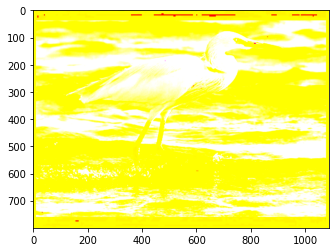

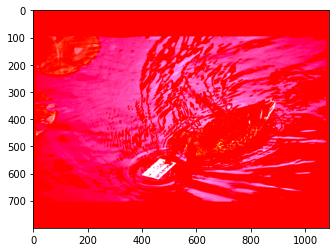

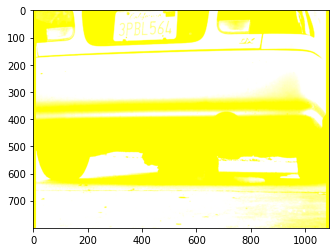

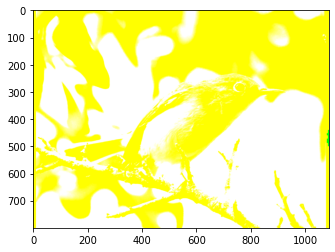

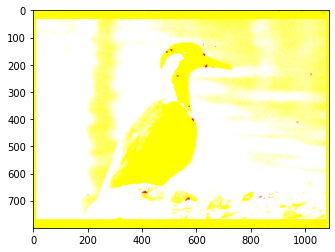

In [ ]:
for i,(mask,label) in enumerate(zip(mask_inferred,label_inferred)):
  plot_inferred_masks(images[i],mask,label)

In [ ]:
# Forward Pass
model.eval()
cat_pred,mask_pred = model(images)
category_targets,mask_targets,active_masks = model.generate_targets(bboxes,labels,masks)
category_targets = np.array(category_targets,dtype=np.object)
mask_targets = np.array(mask_targets,dtype=np.object)
active_masks = np.array(active_masks,dtype=np.object)
focal_loss,mask_loss,loss = model.loss(cat_pred,mask_pred,category_targets,mask_targets,active_masks)
print('focal_Loss {}'.format(focal_loss))
print('mask_loss {}'.format(mask_loss))
print('total_loss {}'.format(loss))

### Part B Submission
In addition to the code you used, you should submit a pdf containing the following plots:
* Dataset visualization plots such as fig. 5 and 6. You should include at least five examples and at least two examples that contain multiple objects. Additionally, the images should cover a range of scales and object classes.
* Target assignment plots such as fig. 8 and 9. You should include at least five examples and at least two examples that contain multiple objects. Additionally, the images should cover a range of scales and object classes.
* Final inference results such as figs. 11-14. You should include at least five examples and at least two examples that contain multiple objects. Additionally, the images should cover a range of scales and object classes.
* Training and validation loss curves. These should include the focal loss, dice loss, and total loss as seperate quantities.

We should be able to reproduce your results with a single function call or cell evaluation. Please specify the method to do so. You do not, however, need to submit your trained weights.

In addition, you should include a discussion of any issues you encountered during this project and any changes you made to the siggested architecture. If you made any interesting observations or thoughts about potential improvements, you should also include them here.

There will likely be a performance benchmark for this project - more details to be announced.

learning rate 0.01 batch size 8 and momentum 0.9 ran into infinite loss issue
lr = 0.008 bs =10 mom = 0.9 

lr = 0.01/4 bs =4 mom =0.9 val_loss increases

lr = 0.015/5,weight_decay=2.5e-4,momentum=0.85 bs = 5

lr = 0.01/5 bs = 5 mom =0.95  w_decay =2e-4

lr = 0.02/5 bs = 5 mom =0.80  w_decay =1.5e-4